In [1]:
# ========================
# JAPANESE SENTIMENT ANALYSIS WITH EMBEDDINGS + XGBOOST + OPTUNA + SHAP
# Compatible with Kaggle T4 GPU and Colab T4 GPU
# ========================

# 0. SETUP & INSTALL
!pip install transformers datasets optuna xgboost shap fugashi ipadic unidic-lite sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.9 MB/s eta 0:00:00:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 36.5 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

2025-07-03 16:50:35.634135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751561435.826892      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751561435.879857      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading WRIME dataset...
Train size: 34560, Test size: 8640
Sentiment distribution:
Train: [9343, 14922, 10295]
Test: [2336, 3731, 2573]

EMBEDDING EXTRACTION WITH MULTIPLE MODELS
Available embedding models:
  - japanese_bert: cl-tohoku/bert-base-japanese-whole-word-masking
  - japanese_roberta: rinna/japanese-roberta-base
  - multilingual_e5: intfloat/multilingual-e5-base
  - e5_small: intfloat/e5-small-v2
Using device: cuda

--- Processing multilingual_e5 ---
Loading SentenceTransformer model: intfloat/multilingual-e5-base


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Extracting embeddings using intfloat/multilingual-e5-base (SentenceTransformer)...


Processing intfloat/multilingual-e5-base:   0%|          | 0/2160 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 1/2160 [00:00<20:25,  1.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 2/2160 [00:00<11:15,  3.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 4/2160 [00:00<05:48,  6.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 6/2160 [00:00<04:09,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 8/2160 [00:01<03:26, 10.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 10/2160 [00:01<03:03, 11.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 12/2160 [00:01<02:53, 12.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 14/2160 [00:01<02:46, 12.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 16/2160 [00:01<02:38, 13.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 18/2160 [00:01<02:35, 13.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 20/2160 [00:01<02:36, 13.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 22/2160 [00:02<02:37, 13.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 24/2160 [00:02<02:34, 13.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|▏         | 27/2160 [00:02<02:14, 15.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|▏         | 29/2160 [00:02<02:20, 15.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|▏         | 31/2160 [00:02<02:13, 15.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 33/2160 [00:02<02:12, 16.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 35/2160 [00:02<02:22, 14.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 37/2160 [00:03<02:28, 14.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 39/2160 [00:03<02:33, 13.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 41/2160 [00:03<02:29, 14.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 43/2160 [00:03<02:29, 14.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 45/2160 [00:03<02:23, 14.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 47/2160 [00:03<02:26, 14.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 49/2160 [00:03<02:19, 15.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 51/2160 [00:04<02:15, 15.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 53/2160 [00:04<02:12, 15.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 56/2160 [00:04<02:05, 16.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 58/2160 [00:04<02:11, 16.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 60/2160 [00:04<02:16, 15.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 62/2160 [00:04<02:12, 15.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 64/2160 [00:04<02:06, 16.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 66/2160 [00:05<02:32, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 68/2160 [00:05<02:21, 14.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 70/2160 [00:05<02:24, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 72/2160 [00:05<02:24, 14.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 74/2160 [00:05<02:30, 13.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▎         | 76/2160 [00:05<02:25, 14.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▎         | 78/2160 [00:05<02:27, 14.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 81/2160 [00:05<02:14, 15.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 83/2160 [00:06<02:17, 15.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 85/2160 [00:06<02:20, 14.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 87/2160 [00:06<02:23, 14.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 89/2160 [00:06<02:16, 15.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 91/2160 [00:06<02:18, 14.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 93/2160 [00:06<02:18, 14.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 95/2160 [00:06<02:22, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 97/2160 [00:07<02:25, 14.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▍         | 99/2160 [00:07<02:13, 15.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▍         | 101/2160 [00:07<02:10, 15.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▍         | 103/2160 [00:07<02:13, 15.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▍         | 105/2160 [00:07<02:12, 15.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▍         | 107/2160 [00:07<02:08, 16.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▌         | 109/2160 [00:07<02:02, 16.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▌         | 111/2160 [00:07<02:06, 16.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▌         | 113/2160 [00:08<02:15, 15.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▌         | 115/2160 [00:08<02:18, 14.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▌         | 117/2160 [00:08<02:16, 14.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 119/2160 [00:08<02:20, 14.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 121/2160 [00:08<02:10, 15.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 123/2160 [00:08<02:08, 15.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 125/2160 [00:08<02:01, 16.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 127/2160 [00:08<02:01, 16.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 129/2160 [00:09<01:59, 17.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 131/2160 [00:09<02:03, 16.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 133/2160 [00:09<02:03, 16.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▋         | 135/2160 [00:09<02:05, 16.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▋         | 137/2160 [00:09<02:13, 15.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▋         | 140/2160 [00:09<02:01, 16.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 142/2160 [00:09<02:01, 16.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 144/2160 [00:10<02:05, 16.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 146/2160 [00:10<02:02, 16.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 148/2160 [00:10<01:59, 16.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 150/2160 [00:10<02:02, 16.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 152/2160 [00:10<02:04, 16.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 154/2160 [00:10<02:09, 15.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 156/2160 [00:10<02:19, 14.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 158/2160 [00:10<02:09, 15.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 160/2160 [00:11<02:17, 14.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 162/2160 [00:11<02:23, 13.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 164/2160 [00:11<02:25, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 166/2160 [00:11<02:22, 13.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 168/2160 [00:11<02:13, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 170/2160 [00:11<02:05, 15.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 172/2160 [00:11<02:08, 15.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 174/2160 [00:12<02:08, 15.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 176/2160 [00:12<02:06, 15.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 178/2160 [00:12<02:08, 15.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 180/2160 [00:12<02:12, 14.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 182/2160 [00:12<02:07, 15.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▊         | 184/2160 [00:12<02:05, 15.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▊         | 186/2160 [00:12<02:09, 15.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▊         | 188/2160 [00:12<02:12, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 190/2160 [00:13<02:16, 14.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 192/2160 [00:13<02:19, 14.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 194/2160 [00:13<02:17, 14.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 196/2160 [00:13<02:09, 15.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 198/2160 [00:13<02:02, 16.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 200/2160 [00:13<02:04, 15.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 202/2160 [00:13<02:09, 15.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 204/2160 [00:14<02:09, 15.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|▉         | 206/2160 [00:14<02:13, 14.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|▉         | 208/2160 [00:14<02:10, 14.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|▉         | 210/2160 [00:14<02:12, 14.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|▉         | 212/2160 [00:14<02:04, 15.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|▉         | 214/2160 [00:14<02:02, 15.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 216/2160 [00:14<01:57, 16.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 218/2160 [00:14<02:10, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 220/2160 [00:15<02:11, 14.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 222/2160 [00:15<02:11, 14.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 224/2160 [00:15<02:08, 15.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 226/2160 [00:15<02:11, 14.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 228/2160 [00:15<02:09, 14.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 230/2160 [00:15<02:09, 14.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 232/2160 [00:15<02:06, 15.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 234/2160 [00:16<02:09, 14.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 236/2160 [00:16<02:12, 14.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 238/2160 [00:16<02:12, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 240/2160 [00:16<02:12, 14.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 242/2160 [00:16<02:17, 13.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█▏        | 244/2160 [00:16<02:07, 15.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█▏        | 246/2160 [00:16<02:08, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█▏        | 248/2160 [00:16<02:08, 14.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 250/2160 [00:17<01:59, 16.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 252/2160 [00:17<02:01, 15.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 254/2160 [00:17<02:08, 14.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 256/2160 [00:17<02:01, 15.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 258/2160 [00:17<02:02, 15.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 260/2160 [00:17<02:08, 14.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 262/2160 [00:17<02:02, 15.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 264/2160 [00:17<02:00, 15.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 266/2160 [00:18<02:06, 14.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 268/2160 [00:18<02:14, 14.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▎        | 270/2160 [00:18<02:15, 13.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 272/2160 [00:18<02:04, 15.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 274/2160 [00:18<02:19, 13.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 276/2160 [00:18<02:11, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 278/2160 [00:19<02:20, 13.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 280/2160 [00:19<02:10, 14.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 282/2160 [00:19<02:01, 15.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 284/2160 [00:19<02:08, 14.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 286/2160 [00:19<02:05, 14.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 288/2160 [00:19<02:09, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 290/2160 [00:19<02:14, 13.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▎        | 292/2160 [00:19<02:04, 15.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▎        | 295/2160 [00:20<01:49, 16.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 298/2160 [00:20<01:44, 17.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 300/2160 [00:20<01:46, 17.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 302/2160 [00:20<02:02, 15.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 304/2160 [00:20<02:05, 14.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 306/2160 [00:20<02:07, 14.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 308/2160 [00:20<02:08, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 310/2160 [00:21<02:21, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 312/2160 [00:21<02:21, 13.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▍        | 314/2160 [00:21<02:21, 13.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▍        | 316/2160 [00:21<02:19, 13.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▍        | 319/2160 [00:21<02:03, 14.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▍        | 321/2160 [00:21<01:55, 15.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▍        | 323/2160 [00:21<01:54, 16.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▌        | 325/2160 [00:22<02:00, 15.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▌        | 327/2160 [00:22<02:07, 14.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▌        | 329/2160 [00:22<02:05, 14.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▌        | 331/2160 [00:22<02:00, 15.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▌        | 333/2160 [00:22<01:59, 15.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 335/2160 [00:22<02:08, 14.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 337/2160 [00:22<02:05, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 339/2160 [00:23<02:08, 14.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 341/2160 [00:23<02:13, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 343/2160 [00:23<02:20, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 345/2160 [00:23<02:08, 14.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 347/2160 [00:23<02:04, 14.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 349/2160 [00:23<02:13, 13.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▋        | 351/2160 [00:23<02:08, 14.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▋        | 353/2160 [00:24<02:09, 13.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▋        | 355/2160 [00:24<02:04, 14.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 357/2160 [00:24<02:01, 14.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 359/2160 [00:24<01:56, 15.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 361/2160 [00:24<01:57, 15.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 363/2160 [00:24<01:54, 15.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 365/2160 [00:24<02:08, 13.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 367/2160 [00:25<02:11, 13.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 369/2160 [00:25<02:13, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 371/2160 [00:25<02:10, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 373/2160 [00:25<02:14, 13.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 375/2160 [00:25<02:12, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 377/2160 [00:25<02:05, 14.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 379/2160 [00:25<01:59, 14.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 381/2160 [00:26<01:58, 15.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 383/2160 [00:26<01:57, 15.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 385/2160 [00:26<02:03, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 387/2160 [00:26<01:59, 14.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 389/2160 [00:26<02:06, 13.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 391/2160 [00:26<02:04, 14.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 393/2160 [00:26<02:00, 14.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 395/2160 [00:27<01:57, 14.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 397/2160 [00:27<02:02, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 399/2160 [00:27<02:01, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▊        | 401/2160 [00:27<01:52, 15.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▊        | 403/2160 [00:27<01:45, 16.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 405/2160 [00:27<01:45, 16.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 407/2160 [00:27<01:47, 16.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 409/2160 [00:27<01:47, 16.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 411/2160 [00:28<01:51, 15.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 413/2160 [00:28<01:50, 15.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 415/2160 [00:28<01:51, 15.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 417/2160 [00:28<01:44, 16.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 419/2160 [00:28<01:44, 16.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 421/2160 [00:28<01:52, 15.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|█▉        | 423/2160 [00:28<01:49, 15.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|█▉        | 425/2160 [00:28<01:50, 15.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|█▉        | 427/2160 [00:29<01:50, 15.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|█▉        | 429/2160 [00:29<02:00, 14.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|█▉        | 431/2160 [00:29<02:10, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 433/2160 [00:29<02:07, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 435/2160 [00:29<02:09, 13.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 437/2160 [00:29<02:03, 13.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 439/2160 [00:29<02:06, 13.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 441/2160 [00:30<02:08, 13.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 443/2160 [00:30<02:12, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 445/2160 [00:30<02:04, 13.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 447/2160 [00:30<02:03, 13.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 449/2160 [00:30<02:07, 13.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 451/2160 [00:31<04:06,  6.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 453/2160 [00:31<03:32,  8.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 455/2160 [00:31<03:03,  9.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 457/2160 [00:31<02:35, 10.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██▏       | 459/2160 [00:31<02:21, 12.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██▏       | 461/2160 [00:31<02:16, 12.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██▏       | 463/2160 [00:32<02:08, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 465/2160 [00:32<02:11, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 467/2160 [00:32<02:07, 13.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 469/2160 [00:32<02:05, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 471/2160 [00:32<02:01, 13.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 473/2160 [00:32<02:05, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 475/2160 [00:33<02:04, 13.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 477/2160 [00:33<02:02, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 479/2160 [00:33<02:01, 13.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 481/2160 [00:33<01:56, 14.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 483/2160 [00:33<01:51, 15.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 485/2160 [00:33<01:44, 15.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 487/2160 [00:33<01:39, 16.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 489/2160 [00:33<01:51, 14.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 491/2160 [00:34<01:54, 14.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 493/2160 [00:34<01:59, 14.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 495/2160 [00:34<01:57, 14.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 497/2160 [00:34<01:50, 15.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 499/2160 [00:34<01:50, 14.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 501/2160 [00:34<01:49, 15.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 503/2160 [00:34<01:44, 15.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 505/2160 [00:34<01:46, 15.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 507/2160 [00:35<01:48, 15.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▎       | 509/2160 [00:35<01:43, 15.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▎       | 511/2160 [00:35<01:39, 16.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 514/2160 [00:35<01:38, 16.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 516/2160 [00:35<01:49, 14.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 518/2160 [00:35<01:48, 15.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 520/2160 [00:35<01:51, 14.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 522/2160 [00:36<01:55, 14.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 524/2160 [00:36<01:52, 14.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 526/2160 [00:36<01:56, 14.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 528/2160 [00:36<01:53, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▍       | 530/2160 [00:36<01:50, 14.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▍       | 532/2160 [00:36<01:47, 15.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▍       | 534/2160 [00:36<01:49, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▍       | 536/2160 [00:37<01:51, 14.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▍       | 538/2160 [00:37<01:51, 14.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 540/2160 [00:37<01:45, 15.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 542/2160 [00:37<01:48, 14.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 544/2160 [00:37<01:50, 14.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 546/2160 [00:37<01:55, 13.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 548/2160 [00:37<01:54, 14.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 550/2160 [00:38<01:56, 13.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 552/2160 [00:38<01:55, 13.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 554/2160 [00:38<02:00, 13.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 556/2160 [00:38<02:01, 13.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 558/2160 [00:38<01:59, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 560/2160 [00:38<01:53, 14.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 562/2160 [00:38<01:49, 14.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 564/2160 [00:39<01:51, 14.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 566/2160 [00:39<01:43, 15.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▋       | 568/2160 [00:39<01:48, 14.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▋       | 570/2160 [00:39<01:52, 14.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▋       | 572/2160 [00:39<01:49, 14.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 574/2160 [00:39<01:46, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 576/2160 [00:39<01:45, 15.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 578/2160 [00:39<01:40, 15.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 580/2160 [00:40<01:38, 16.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 582/2160 [00:40<01:37, 16.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 584/2160 [00:40<01:38, 16.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 586/2160 [00:40<01:40, 15.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 588/2160 [00:40<01:40, 15.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 590/2160 [00:40<01:44, 15.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 592/2160 [00:40<01:39, 15.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 594/2160 [00:41<01:44, 14.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 596/2160 [00:41<01:43, 15.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 598/2160 [00:41<01:38, 15.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 600/2160 [00:41<01:46, 14.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 602/2160 [00:41<01:45, 14.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 604/2160 [00:41<01:48, 14.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 606/2160 [00:41<01:49, 14.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 608/2160 [00:41<01:49, 14.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 610/2160 [00:42<01:52, 13.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 612/2160 [00:42<01:44, 14.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 614/2160 [00:42<01:43, 14.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▊       | 616/2160 [00:42<01:43, 14.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▊       | 618/2160 [00:42<01:41, 15.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▊       | 620/2160 [00:42<01:41, 15.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 622/2160 [00:42<01:42, 14.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 624/2160 [00:43<01:42, 15.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 626/2160 [00:43<01:48, 14.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 628/2160 [00:43<01:42, 14.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 630/2160 [00:43<01:46, 14.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 632/2160 [00:43<01:46, 14.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 634/2160 [00:43<01:47, 14.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 636/2160 [00:43<01:43, 14.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|██▉       | 638/2160 [00:44<01:48, 14.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|██▉       | 640/2160 [00:44<01:43, 14.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|██▉       | 642/2160 [00:44<01:47, 14.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|██▉       | 644/2160 [00:44<01:45, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|██▉       | 646/2160 [00:44<01:46, 14.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 648/2160 [00:44<01:42, 14.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 650/2160 [00:44<01:46, 14.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 652/2160 [00:44<01:44, 14.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 654/2160 [00:45<01:42, 14.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 656/2160 [00:45<01:43, 14.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 658/2160 [00:45<01:37, 15.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 660/2160 [00:45<01:39, 15.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 662/2160 [00:45<01:46, 14.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 664/2160 [00:45<01:48, 13.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 666/2160 [00:45<01:43, 14.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 668/2160 [00:46<01:44, 14.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 670/2160 [00:46<01:40, 14.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 672/2160 [00:46<01:47, 13.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 674/2160 [00:46<01:48, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███▏      | 676/2160 [00:46<01:49, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███▏      | 678/2160 [00:46<01:47, 13.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███▏      | 680/2160 [00:46<01:42, 14.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 682/2160 [00:47<01:44, 14.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 684/2160 [00:47<01:45, 14.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 686/2160 [00:47<01:41, 14.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 688/2160 [00:47<01:40, 14.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 690/2160 [00:47<01:39, 14.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 692/2160 [00:47<01:33, 15.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 694/2160 [00:47<01:38, 14.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 696/2160 [00:48<01:46, 13.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 698/2160 [00:48<01:46, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 700/2160 [00:48<01:48, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▎      | 702/2160 [00:48<01:46, 13.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 704/2160 [00:48<01:43, 14.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 706/2160 [00:48<01:35, 15.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 708/2160 [00:48<01:41, 14.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 710/2160 [00:49<01:42, 14.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 712/2160 [00:49<01:39, 14.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 714/2160 [00:49<01:37, 14.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 716/2160 [00:49<01:40, 14.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 718/2160 [00:49<01:44, 13.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 720/2160 [00:49<01:39, 14.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 722/2160 [00:49<01:40, 14.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▎      | 724/2160 [00:50<01:41, 14.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▎      | 727/2160 [00:50<01:35, 15.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 729/2160 [00:50<01:33, 15.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 731/2160 [00:50<01:31, 15.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 733/2160 [00:50<01:36, 14.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 735/2160 [00:50<01:48, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 737/2160 [00:50<01:46, 13.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 739/2160 [00:51<01:45, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 741/2160 [00:51<01:41, 13.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 743/2160 [00:51<01:40, 14.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 745/2160 [00:51<01:35, 14.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▍      | 747/2160 [00:51<01:36, 14.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▍      | 749/2160 [00:51<01:37, 14.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▍      | 751/2160 [00:51<01:36, 14.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▍      | 753/2160 [00:52<01:36, 14.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▍      | 755/2160 [00:52<01:38, 14.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▌      | 757/2160 [00:52<01:38, 14.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▌      | 759/2160 [00:52<01:38, 14.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▌      | 761/2160 [00:52<01:43, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▌      | 763/2160 [00:52<01:44, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▌      | 765/2160 [00:52<01:40, 13.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 767/2160 [00:53<01:41, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 769/2160 [00:53<01:37, 14.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 771/2160 [00:53<01:37, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 773/2160 [00:53<01:41, 13.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 775/2160 [00:53<01:45, 13.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 777/2160 [00:53<01:53, 12.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 779/2160 [00:53<01:48, 12.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 781/2160 [00:54<01:47, 12.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▋      | 783/2160 [00:54<01:42, 13.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▋      | 785/2160 [00:54<01:41, 13.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▋      | 787/2160 [00:54<01:32, 14.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 789/2160 [00:54<01:35, 14.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 791/2160 [00:54<01:37, 14.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 793/2160 [00:54<01:36, 14.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 795/2160 [00:55<01:37, 13.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 797/2160 [00:55<01:38, 13.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 799/2160 [00:55<01:34, 14.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 801/2160 [00:55<01:36, 14.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 803/2160 [00:55<01:33, 14.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 805/2160 [00:55<01:33, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 807/2160 [00:55<01:26, 15.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 809/2160 [00:56<01:22, 16.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 811/2160 [00:56<01:27, 15.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 813/2160 [00:56<01:32, 14.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 815/2160 [00:56<01:31, 14.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 817/2160 [00:56<01:29, 15.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 819/2160 [00:56<01:35, 13.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 821/2160 [00:56<01:32, 14.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 823/2160 [00:56<01:27, 15.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 825/2160 [00:57<01:32, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 827/2160 [00:57<01:29, 14.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 829/2160 [00:57<01:29, 14.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 831/2160 [00:57<01:34, 14.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▊      | 833/2160 [00:57<01:43, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▊      | 835/2160 [00:57<01:40, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 837/2160 [00:58<01:40, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 839/2160 [00:58<01:38, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 841/2160 [00:58<01:35, 13.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 843/2160 [00:58<01:34, 13.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 845/2160 [00:58<01:32, 14.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 847/2160 [00:58<01:35, 13.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 849/2160 [00:58<01:42, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 851/2160 [00:59<01:41, 12.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 853/2160 [00:59<01:36, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|███▉      | 855/2160 [00:59<01:38, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|███▉      | 857/2160 [00:59<01:36, 13.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|███▉      | 859/2160 [00:59<01:29, 14.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|███▉      | 861/2160 [00:59<01:34, 13.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|███▉      | 863/2160 [00:59<01:31, 14.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 865/2160 [01:00<01:33, 13.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 867/2160 [01:00<01:37, 13.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 869/2160 [01:00<01:32, 13.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 871/2160 [01:00<01:38, 13.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 873/2160 [01:00<01:40, 12.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 875/2160 [01:00<01:33, 13.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 877/2160 [01:00<01:35, 13.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 879/2160 [01:01<01:41, 12.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 881/2160 [01:01<01:36, 13.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 883/2160 [01:01<01:39, 12.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 885/2160 [01:01<01:33, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 887/2160 [01:01<01:33, 13.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 889/2160 [01:01<01:30, 14.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████▏     | 891/2160 [01:02<01:30, 14.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████▏     | 893/2160 [01:02<01:31, 13.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████▏     | 895/2160 [01:02<01:26, 14.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 897/2160 [01:02<01:27, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 899/2160 [01:02<01:31, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 901/2160 [01:02<01:29, 14.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 903/2160 [01:02<01:24, 14.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 905/2160 [01:02<01:27, 14.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 907/2160 [01:03<01:22, 15.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 909/2160 [01:03<01:21, 15.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 911/2160 [01:03<01:26, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 913/2160 [01:03<01:30, 13.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 915/2160 [01:03<01:30, 13.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 917/2160 [01:03<01:32, 13.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 919/2160 [01:03<01:27, 14.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 921/2160 [01:04<01:31, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 923/2160 [01:04<01:32, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 925/2160 [01:04<01:31, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 927/2160 [01:04<01:28, 13.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 929/2160 [01:04<01:27, 14.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 931/2160 [01:04<01:28, 13.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 934/2160 [01:05<01:21, 15.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 936/2160 [01:05<01:19, 15.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 938/2160 [01:05<01:16, 16.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▎     | 940/2160 [01:05<01:18, 15.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▎     | 942/2160 [01:05<01:23, 14.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▎     | 944/2160 [01:05<01:22, 14.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 946/2160 [01:05<01:19, 15.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 948/2160 [01:05<01:21, 14.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 950/2160 [01:06<01:20, 14.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 952/2160 [01:06<01:22, 14.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 954/2160 [01:06<01:25, 14.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 956/2160 [01:06<01:30, 13.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 958/2160 [01:06<01:31, 13.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 960/2160 [01:06<01:30, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▍     | 962/2160 [01:06<01:28, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▍     | 964/2160 [01:07<01:24, 14.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▍     | 966/2160 [01:07<01:27, 13.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▍     | 968/2160 [01:07<01:21, 14.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▍     | 970/2160 [01:07<01:23, 14.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 972/2160 [01:07<01:29, 13.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 974/2160 [01:07<01:24, 13.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 976/2160 [01:07<01:22, 14.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 978/2160 [01:08<01:20, 14.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 980/2160 [01:08<01:21, 14.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 982/2160 [01:08<01:22, 14.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 984/2160 [01:08<01:22, 14.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 986/2160 [01:08<01:17, 15.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 988/2160 [01:08<01:19, 14.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 990/2160 [01:08<01:23, 14.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 992/2160 [01:09<01:21, 14.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 994/2160 [01:09<01:21, 14.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 996/2160 [01:09<01:21, 14.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 998/2160 [01:09<01:18, 14.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▋     | 1000/2160 [01:09<01:16, 15.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▋     | 1002/2160 [01:09<01:16, 15.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▋     | 1004/2160 [01:09<01:13, 15.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1006/2160 [01:10<01:17, 14.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1008/2160 [01:10<01:13, 15.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1010/2160 [01:10<01:12, 15.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1012/2160 [01:10<01:17, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1014/2160 [01:10<01:14, 15.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1016/2160 [01:10<01:12, 15.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1018/2160 [01:10<01:14, 15.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1020/2160 [01:10<01:23, 13.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1022/2160 [01:11<01:18, 14.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 1024/2160 [01:11<01:16, 14.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1026/2160 [01:11<01:17, 14.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1028/2160 [01:11<01:18, 14.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1030/2160 [01:11<01:16, 14.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1032/2160 [01:11<01:13, 15.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1034/2160 [01:11<01:11, 15.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1036/2160 [01:11<01:15, 14.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1038/2160 [01:12<01:13, 15.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1040/2160 [01:12<01:15, 14.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1042/2160 [01:12<01:14, 14.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1044/2160 [01:12<01:11, 15.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 1046/2160 [01:12<01:16, 14.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▊     | 1048/2160 [01:12<01:14, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▊     | 1050/2160 [01:12<01:15, 14.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▊     | 1052/2160 [01:13<01:17, 14.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1054/2160 [01:13<01:19, 13.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1056/2160 [01:13<01:23, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1058/2160 [01:13<01:18, 14.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1060/2160 [01:13<01:17, 14.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1062/2160 [01:13<01:12, 15.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1064/2160 [01:13<01:13, 14.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1066/2160 [01:14<01:10, 15.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 1068/2160 [01:14<01:11, 15.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|████▉     | 1070/2160 [01:14<01:16, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|████▉     | 1072/2160 [01:14<01:11, 15.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|████▉     | 1074/2160 [01:14<01:07, 16.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|████▉     | 1076/2160 [01:14<01:12, 14.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|████▉     | 1078/2160 [01:14<01:16, 14.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 1080/2160 [01:15<01:16, 14.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 1082/2160 [01:15<01:18, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 1084/2160 [01:15<01:17, 13.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 1086/2160 [01:15<01:17, 13.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 1088/2160 [01:15<01:18, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1091/2160 [01:15<01:07, 15.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1093/2160 [01:15<01:07, 15.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1095/2160 [01:15<01:05, 16.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1097/2160 [01:16<01:08, 15.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1099/2160 [01:16<01:07, 15.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1101/2160 [01:16<01:10, 15.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1103/2160 [01:16<01:15, 14.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 1105/2160 [01:16<01:16, 13.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████▏    | 1107/2160 [01:16<01:16, 13.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████▏    | 1109/2160 [01:16<01:10, 14.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████▏    | 1111/2160 [01:17<01:09, 15.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1113/2160 [01:17<01:10, 14.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1115/2160 [01:17<01:12, 14.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1117/2160 [01:17<01:13, 14.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1119/2160 [01:17<01:14, 14.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1121/2160 [01:17<01:15, 13.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1123/2160 [01:17<01:11, 14.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1125/2160 [01:18<01:14, 13.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1127/2160 [01:18<01:15, 13.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1129/2160 [01:18<01:11, 14.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1131/2160 [01:18<01:14, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 1133/2160 [01:18<01:11, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1135/2160 [01:18<01:13, 14.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1137/2160 [01:18<01:16, 13.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1139/2160 [01:19<01:15, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1141/2160 [01:19<01:17, 13.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1143/2160 [01:19<01:20, 12.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1145/2160 [01:19<01:19, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1147/2160 [01:19<01:15, 13.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1149/2160 [01:19<01:18, 12.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1151/2160 [01:20<01:14, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1153/2160 [01:20<01:15, 13.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 1155/2160 [01:20<01:14, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▎    | 1157/2160 [01:20<01:14, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▎    | 1159/2160 [01:20<01:11, 13.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1161/2160 [01:20<01:12, 13.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1163/2160 [01:20<01:09, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1165/2160 [01:21<01:08, 14.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1167/2160 [01:21<01:13, 13.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1169/2160 [01:21<01:13, 13.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1171/2160 [01:21<01:10, 13.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1173/2160 [01:21<01:14, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1175/2160 [01:21<01:16, 12.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 1177/2160 [01:21<01:16, 12.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▍    | 1179/2160 [01:22<01:18, 12.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▍    | 1181/2160 [01:22<01:15, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▍    | 1183/2160 [01:22<01:15, 12.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▍    | 1185/2160 [01:22<01:12, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▍    | 1187/2160 [01:22<01:16, 12.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▌    | 1189/2160 [01:22<01:14, 13.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▌    | 1191/2160 [01:23<01:09, 13.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▌    | 1193/2160 [01:23<01:08, 14.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▌    | 1195/2160 [01:23<01:10, 13.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▌    | 1197/2160 [01:23<01:13, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1200/2160 [01:23<01:03, 15.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1202/2160 [01:23<01:01, 15.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1204/2160 [01:23<01:02, 15.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1206/2160 [01:24<01:04, 14.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1208/2160 [01:24<01:04, 14.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1210/2160 [01:24<01:05, 14.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1212/2160 [01:24<01:07, 14.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 1214/2160 [01:24<01:11, 13.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▋    | 1216/2160 [01:24<01:14, 12.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▋    | 1218/2160 [01:24<01:11, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▋    | 1220/2160 [01:25<01:10, 13.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1222/2160 [01:25<01:10, 13.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1224/2160 [01:25<01:05, 14.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1226/2160 [01:25<01:09, 13.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1228/2160 [01:25<01:10, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1230/2160 [01:25<01:10, 13.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1232/2160 [01:25<01:09, 13.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1234/2160 [01:26<01:07, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1236/2160 [01:26<01:04, 14.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1238/2160 [01:26<01:02, 14.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 1240/2160 [01:26<01:02, 14.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▊    | 1242/2160 [01:26<01:04, 14.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1244/2160 [01:26<01:00, 15.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1246/2160 [01:26<00:59, 15.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1248/2160 [01:27<01:03, 14.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1250/2160 [01:27<01:05, 13.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1252/2160 [01:27<01:08, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1254/2160 [01:27<01:07, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1256/2160 [01:27<01:06, 13.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1258/2160 [01:27<01:08, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1260/2160 [01:27<01:06, 13.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 1262/2160 [01:28<01:05, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▊    | 1264/2160 [01:28<01:07, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▊    | 1266/2160 [01:28<01:07, 13.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▊    | 1268/2160 [01:28<01:07, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1270/2160 [01:28<01:06, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1272/2160 [01:28<01:04, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1274/2160 [01:29<01:07, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1276/2160 [01:29<01:08, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1278/2160 [01:29<01:05, 13.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1280/2160 [01:29<01:06, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1282/2160 [01:29<01:05, 13.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 1284/2160 [01:29<01:05, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|█████▉    | 1286/2160 [01:29<01:06, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|█████▉    | 1288/2160 [01:30<01:03, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|█████▉    | 1290/2160 [01:30<01:04, 13.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|█████▉    | 1292/2160 [01:30<01:07, 12.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|█████▉    | 1294/2160 [01:30<01:04, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 1296/2160 [01:30<01:01, 13.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 1298/2160 [01:30<01:02, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 1300/2160 [01:30<01:06, 12.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 1302/2160 [01:31<01:13, 11.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 1304/2160 [01:31<01:08, 12.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 1306/2160 [01:31<01:08, 12.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1308/2160 [01:31<01:02, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1310/2160 [01:31<01:01, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1312/2160 [01:31<01:02, 13.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1314/2160 [01:32<01:00, 13.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1316/2160 [01:32<01:03, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1318/2160 [01:32<01:03, 13.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1320/2160 [01:32<01:01, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 1322/2160 [01:32<01:00, 13.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████▏   | 1324/2160 [01:32<00:58, 14.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████▏   | 1326/2160 [01:32<00:55, 15.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████▏   | 1328/2160 [01:33<00:57, 14.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1330/2160 [01:33<00:54, 15.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1332/2160 [01:33<01:00, 13.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1334/2160 [01:33<01:01, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1336/2160 [01:33<00:59, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1338/2160 [01:33<01:03, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1340/2160 [01:33<01:05, 12.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1342/2160 [01:34<01:03, 12.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1344/2160 [01:34<01:03, 12.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1346/2160 [01:34<01:03, 12.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 1348/2160 [01:34<01:02, 12.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▎   | 1350/2160 [01:34<01:04, 12.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1352/2160 [01:34<01:04, 12.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1354/2160 [01:35<01:04, 12.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1356/2160 [01:35<00:58, 13.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1358/2160 [01:35<00:55, 14.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1360/2160 [01:35<00:55, 14.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1362/2160 [01:35<00:57, 13.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1364/2160 [01:35<01:02, 12.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1366/2160 [01:35<00:58, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1368/2160 [01:36<01:02, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 1370/2160 [01:36<01:00, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▎   | 1373/2160 [01:36<00:52, 15.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▎   | 1375/2160 [01:36<00:55, 14.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1377/2160 [01:36<00:53, 14.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1379/2160 [01:36<00:53, 14.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1381/2160 [01:36<00:52, 14.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1383/2160 [01:37<00:54, 14.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1385/2160 [01:37<00:52, 14.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1387/2160 [01:37<00:54, 14.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1389/2160 [01:37<00:56, 13.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1391/2160 [01:37<00:57, 13.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 1393/2160 [01:37<00:59, 12.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▍   | 1395/2160 [01:38<01:00, 12.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▍   | 1397/2160 [01:38<01:01, 12.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▍   | 1399/2160 [01:38<01:01, 12.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▍   | 1401/2160 [01:38<01:00, 12.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▍   | 1403/2160 [01:38<00:58, 12.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 1405/2160 [01:38<01:01, 12.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 1407/2160 [01:38<00:59, 12.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 1409/2160 [01:39<01:02, 12.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 1411/2160 [01:39<01:02, 12.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 1413/2160 [01:39<01:01, 12.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1415/2160 [01:39<00:58, 12.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1417/2160 [01:39<01:01, 12.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1419/2160 [01:39<00:57, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1421/2160 [01:40<00:56, 13.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1423/2160 [01:40<00:56, 13.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1425/2160 [01:40<00:55, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1427/2160 [01:40<00:50, 14.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 1429/2160 [01:40<00:59, 12.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▋   | 1431/2160 [01:40<00:58, 12.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▋   | 1433/2160 [01:40<00:53, 13.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▋   | 1435/2160 [01:41<00:56, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1437/2160 [01:41<00:58, 12.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1439/2160 [01:41<01:00, 11.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1441/2160 [01:41<00:57, 12.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1443/2160 [01:41<00:55, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1445/2160 [01:41<00:52, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1447/2160 [01:42<00:50, 14.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1449/2160 [01:42<00:53, 13.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1451/2160 [01:42<00:51, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1453/2160 [01:42<00:50, 14.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1455/2160 [01:42<00:50, 14.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 1457/2160 [01:42<00:47, 14.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1459/2160 [01:42<00:51, 13.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1461/2160 [01:43<00:51, 13.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1463/2160 [01:43<00:51, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1465/2160 [01:43<00:49, 13.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1467/2160 [01:43<00:47, 14.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1469/2160 [01:43<00:47, 14.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1471/2160 [01:43<00:49, 14.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1473/2160 [01:43<00:48, 14.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1475/2160 [01:44<00:49, 13.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1477/2160 [01:44<00:49, 13.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 1479/2160 [01:44<00:50, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▊   | 1481/2160 [01:44<00:51, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▊   | 1483/2160 [01:44<00:49, 13.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1485/2160 [01:44<00:50, 13.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1487/2160 [01:44<00:50, 13.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1489/2160 [01:45<00:53, 12.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1491/2160 [01:45<00:54, 12.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1493/2160 [01:45<00:52, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1495/2160 [01:45<00:48, 13.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1497/2160 [01:45<00:50, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1499/2160 [01:45<00:48, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 1501/2160 [01:46<00:49, 13.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|██████▉   | 1503/2160 [01:46<00:50, 13.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|██████▉   | 1505/2160 [01:46<00:51, 12.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|██████▉   | 1507/2160 [01:46<00:52, 12.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|██████▉   | 1509/2160 [01:46<00:47, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|██████▉   | 1511/2160 [01:46<00:47, 13.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|███████   | 1513/2160 [01:46<00:42, 15.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|███████   | 1515/2160 [01:47<00:46, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|███████   | 1517/2160 [01:47<00:50, 12.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|███████   | 1519/2160 [01:47<00:47, 13.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|███████   | 1521/2160 [01:47<00:49, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1523/2160 [01:47<00:49, 12.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1525/2160 [01:47<00:46, 13.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1527/2160 [01:48<00:50, 12.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1529/2160 [01:48<00:48, 13.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1531/2160 [01:48<00:48, 13.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1533/2160 [01:48<00:44, 14.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1535/2160 [01:48<00:46, 13.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 1537/2160 [01:48<00:48, 12.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████▏  | 1539/2160 [01:48<00:46, 13.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████▏  | 1541/2160 [01:49<00:42, 14.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████▏  | 1543/2160 [01:49<00:40, 15.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1545/2160 [01:49<00:44, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1547/2160 [01:49<00:46, 13.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1549/2160 [01:49<00:46, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1551/2160 [01:49<00:45, 13.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1553/2160 [01:49<00:45, 13.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1555/2160 [01:50<00:44, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1557/2160 [01:50<00:45, 13.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1559/2160 [01:50<00:45, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1561/2160 [01:50<00:43, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1563/2160 [01:50<00:44, 13.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 1565/2160 [01:50<00:41, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1567/2160 [01:50<00:41, 14.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1569/2160 [01:51<00:43, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1572/2160 [01:51<00:39, 14.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1574/2160 [01:51<00:43, 13.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1576/2160 [01:51<00:42, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1578/2160 [01:51<00:40, 14.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1580/2160 [01:51<00:40, 14.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1582/2160 [01:51<00:40, 14.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1584/2160 [01:52<00:40, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 1586/2160 [01:52<00:39, 14.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▎  | 1588/2160 [01:52<00:40, 14.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▎  | 1590/2160 [01:52<00:42, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▎  | 1592/2160 [01:52<00:41, 13.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1594/2160 [01:52<00:43, 13.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1596/2160 [01:53<00:45, 12.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1598/2160 [01:53<00:43, 12.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1600/2160 [01:53<00:41, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1602/2160 [01:53<00:41, 13.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1604/2160 [01:53<00:39, 14.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1606/2160 [01:53<00:41, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 1608/2160 [01:53<00:41, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▍  | 1610/2160 [01:54<00:43, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▍  | 1612/2160 [01:54<00:41, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▍  | 1614/2160 [01:54<00:40, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▍  | 1616/2160 [01:54<00:37, 14.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▍  | 1618/2160 [01:54<00:41, 12.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 1620/2160 [01:54<00:42, 12.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 1622/2160 [01:55<00:41, 12.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 1624/2160 [01:55<00:43, 12.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 1626/2160 [01:55<00:41, 12.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 1628/2160 [01:55<00:38, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 1630/2160 [01:55<00:39, 13.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1632/2160 [01:55<00:41, 12.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1634/2160 [01:55<00:42, 12.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1636/2160 [01:56<00:40, 12.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1638/2160 [01:56<00:41, 12.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1640/2160 [01:56<00:38, 13.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1642/2160 [01:56<00:38, 13.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1644/2160 [01:56<00:40, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 1646/2160 [01:56<00:39, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▋  | 1648/2160 [01:56<00:35, 14.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▋  | 1650/2160 [01:57<00:33, 15.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▋  | 1652/2160 [01:57<00:37, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1654/2160 [01:57<00:37, 13.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1656/2160 [01:57<00:37, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1658/2160 [01:57<00:37, 13.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1660/2160 [01:57<00:36, 13.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1662/2160 [01:57<00:36, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1664/2160 [01:58<00:38, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1666/2160 [01:58<00:35, 13.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1668/2160 [01:58<00:36, 13.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1670/2160 [01:58<00:37, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 1672/2160 [01:58<00:37, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1674/2160 [01:58<00:33, 14.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1676/2160 [01:59<00:33, 14.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1678/2160 [01:59<00:36, 13.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1680/2160 [01:59<00:35, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1682/2160 [01:59<00:35, 13.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1684/2160 [01:59<00:37, 12.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1686/2160 [01:59<00:37, 12.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1688/2160 [01:59<00:36, 12.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1690/2160 [02:00<00:38, 12.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1692/2160 [02:00<00:39, 11.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 1694/2160 [02:00<00:37, 12.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▊  | 1696/2160 [02:00<00:33, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▊  | 1698/2160 [02:00<00:34, 13.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▊  | 1700/2160 [02:00<00:36, 12.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1702/2160 [02:01<00:36, 12.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1704/2160 [02:01<00:33, 13.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1706/2160 [02:01<00:34, 13.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1708/2160 [02:01<00:31, 14.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1710/2160 [02:01<00:34, 13.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1712/2160 [02:01<00:32, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1714/2160 [02:02<00:36, 12.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 1716/2160 [02:02<00:34, 13.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|███████▉  | 1718/2160 [02:02<00:31, 14.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|███████▉  | 1720/2160 [02:02<00:31, 14.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|███████▉  | 1722/2160 [02:02<00:30, 14.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|███████▉  | 1724/2160 [02:02<00:30, 14.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|███████▉  | 1726/2160 [02:02<00:28, 14.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 1728/2160 [02:02<00:29, 14.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 1730/2160 [02:03<00:28, 15.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 1732/2160 [02:03<00:30, 14.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 1734/2160 [02:03<00:33, 12.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 1736/2160 [02:03<00:32, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 1738/2160 [02:03<00:31, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1740/2160 [02:03<00:29, 14.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1742/2160 [02:03<00:31, 13.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1744/2160 [02:04<00:28, 14.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1746/2160 [02:04<00:30, 13.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1748/2160 [02:04<00:29, 13.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1750/2160 [02:04<00:31, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1752/2160 [02:04<00:32, 12.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 1754/2160 [02:04<00:31, 12.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████▏ | 1756/2160 [02:05<00:32, 12.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████▏ | 1758/2160 [02:05<00:32, 12.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████▏ | 1760/2160 [02:05<00:30, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1762/2160 [02:05<00:29, 13.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1764/2160 [02:05<00:30, 13.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1766/2160 [02:05<00:30, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1768/2160 [02:05<00:31, 12.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1770/2160 [02:06<00:32, 12.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1772/2160 [02:06<00:30, 12.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1774/2160 [02:06<00:31, 12.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1776/2160 [02:06<00:30, 12.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1778/2160 [02:06<00:30, 12.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 1780/2160 [02:06<00:28, 13.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▎ | 1782/2160 [02:07<00:27, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1784/2160 [02:07<00:26, 14.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1786/2160 [02:07<00:26, 14.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1788/2160 [02:07<00:27, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1790/2160 [02:07<00:28, 13.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1792/2160 [02:07<00:28, 13.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1794/2160 [02:07<00:29, 12.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1796/2160 [02:08<00:29, 12.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1798/2160 [02:08<00:29, 12.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1800/2160 [02:08<00:28, 12.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 1802/2160 [02:08<00:27, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▎ | 1804/2160 [02:08<00:27, 12.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▎ | 1806/2160 [02:08<00:25, 14.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▎ | 1808/2160 [02:09<00:26, 13.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1810/2160 [02:09<00:25, 13.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1812/2160 [02:09<00:24, 14.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1814/2160 [02:09<00:22, 15.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1816/2160 [02:09<00:25, 13.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1818/2160 [02:09<00:26, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1820/2160 [02:09<00:26, 13.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1822/2160 [02:10<00:24, 13.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 1824/2160 [02:10<00:22, 14.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▍ | 1826/2160 [02:10<00:22, 14.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▍ | 1828/2160 [02:10<00:22, 14.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▍ | 1830/2160 [02:10<00:23, 14.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▍ | 1832/2160 [02:10<00:22, 14.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▍ | 1834/2160 [02:10<00:23, 13.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 1836/2160 [02:11<00:23, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 1838/2160 [02:11<00:24, 13.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 1840/2160 [02:11<00:24, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 1842/2160 [02:11<00:25, 12.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 1844/2160 [02:11<00:27, 11.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 1846/2160 [02:11<00:25, 12.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1848/2160 [02:12<00:24, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1850/2160 [02:12<00:24, 12.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1852/2160 [02:12<00:24, 12.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1854/2160 [02:12<00:25, 12.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1856/2160 [02:12<00:23, 12.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1858/2160 [02:12<00:22, 13.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1860/2160 [02:12<00:23, 12.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 1862/2160 [02:13<00:22, 13.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▋ | 1864/2160 [02:13<00:20, 14.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▋ | 1866/2160 [02:13<00:21, 13.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▋ | 1868/2160 [02:13<00:22, 13.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1870/2160 [02:13<00:21, 13.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1872/2160 [02:13<00:21, 13.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1874/2160 [02:13<00:22, 12.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1876/2160 [02:14<00:22, 12.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1878/2160 [02:14<00:22, 12.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1880/2160 [02:14<00:21, 12.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1882/2160 [02:14<00:19, 14.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1884/2160 [02:14<00:19, 13.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1886/2160 [02:14<00:20, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 1888/2160 [02:15<00:21, 12.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1890/2160 [02:15<00:20, 13.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1892/2160 [02:15<00:43,  6.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1894/2160 [02:16<00:35,  7.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1896/2160 [02:16<00:31,  8.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1898/2160 [02:16<00:29,  8.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1900/2160 [02:16<00:27,  9.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1902/2160 [02:16<00:25, 10.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1904/2160 [02:16<00:23, 11.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1906/2160 [02:17<00:21, 12.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1908/2160 [02:17<00:20, 12.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 1910/2160 [02:17<00:20, 12.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▊ | 1912/2160 [02:17<00:19, 12.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▊ | 1914/2160 [02:17<00:19, 12.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▊ | 1916/2160 [02:17<00:18, 13.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1918/2160 [02:17<00:19, 12.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1920/2160 [02:18<00:17, 13.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1922/2160 [02:18<00:17, 13.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1924/2160 [02:18<00:17, 13.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1926/2160 [02:18<00:17, 13.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1928/2160 [02:18<00:17, 13.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1930/2160 [02:18<00:16, 13.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 1932/2160 [02:19<00:17, 13.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|████████▉ | 1934/2160 [02:19<00:17, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|████████▉ | 1936/2160 [02:19<00:16, 13.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|████████▉ | 1938/2160 [02:19<00:18, 12.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|████████▉ | 1940/2160 [02:19<00:18, 11.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|████████▉ | 1942/2160 [02:19<00:17, 12.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 1944/2160 [02:19<00:16, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 1946/2160 [02:20<00:16, 12.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 1948/2160 [02:20<00:16, 12.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 1950/2160 [02:20<00:15, 13.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 1952/2160 [02:20<00:15, 13.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 1954/2160 [02:20<00:15, 13.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1956/2160 [02:20<00:15, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1958/2160 [02:21<00:15, 13.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1960/2160 [02:21<00:13, 14.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1962/2160 [02:21<00:15, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1964/2160 [02:21<00:15, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1966/2160 [02:21<00:13, 13.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1968/2160 [02:21<00:13, 14.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 1970/2160 [02:21<00:13, 13.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████▏| 1972/2160 [02:22<00:14, 13.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████▏| 1974/2160 [02:22<00:15, 11.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████▏| 1976/2160 [02:22<00:15, 11.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1978/2160 [02:22<00:14, 12.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1980/2160 [02:22<00:14, 12.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1982/2160 [02:22<00:14, 11.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1984/2160 [02:23<00:14, 12.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1986/2160 [02:23<00:13, 12.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1988/2160 [02:23<00:14, 11.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1990/2160 [02:23<00:13, 12.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1992/2160 [02:23<00:13, 12.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1994/2160 [02:23<00:13, 12.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 1996/2160 [02:24<00:13, 12.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▎| 1998/2160 [02:24<00:13, 12.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2000/2160 [02:24<00:12, 12.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2002/2160 [02:24<00:11, 14.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2004/2160 [02:24<00:11, 13.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2006/2160 [02:24<00:11, 13.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2008/2160 [02:24<00:11, 12.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2010/2160 [02:25<00:12, 12.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2012/2160 [02:25<00:11, 12.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2014/2160 [02:25<00:10, 13.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2016/2160 [02:25<00:10, 13.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 2018/2160 [02:25<00:09, 14.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▎| 2020/2160 [02:25<00:10, 13.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▎| 2022/2160 [02:25<00:09, 14.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▎| 2024/2160 [02:26<00:09, 14.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2026/2160 [02:26<00:09, 14.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2028/2160 [02:26<00:09, 14.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2030/2160 [02:26<00:09, 13.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2032/2160 [02:26<00:09, 12.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2034/2160 [02:26<00:09, 13.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2036/2160 [02:26<00:09, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2038/2160 [02:27<00:09, 13.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 2040/2160 [02:27<00:08, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▍| 2042/2160 [02:27<00:08, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▍| 2044/2160 [02:27<00:08, 13.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▍| 2046/2160 [02:27<00:08, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▍| 2048/2160 [02:27<00:08, 13.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▍| 2050/2160 [02:28<00:08, 13.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 2052/2160 [02:28<00:08, 13.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 2054/2160 [02:28<00:08, 12.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 2056/2160 [02:28<00:07, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 2058/2160 [02:28<00:08, 12.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 2060/2160 [02:28<00:07, 12.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 2062/2160 [02:28<00:07, 12.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2064/2160 [02:29<00:07, 12.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2066/2160 [02:29<00:07, 13.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2068/2160 [02:29<00:07, 12.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2070/2160 [02:29<00:06, 12.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2072/2160 [02:29<00:06, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2074/2160 [02:29<00:06, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2076/2160 [02:30<00:06, 13.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 2078/2160 [02:30<00:06, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▋| 2080/2160 [02:30<00:05, 13.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▋| 2082/2160 [02:30<00:05, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▋| 2084/2160 [02:30<00:05, 14.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2086/2160 [02:30<00:05, 13.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2088/2160 [02:30<00:05, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2090/2160 [02:31<00:05, 13.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2092/2160 [02:31<00:05, 12.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2094/2160 [02:31<00:04, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2096/2160 [02:31<00:04, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2098/2160 [02:31<00:04, 14.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2100/2160 [02:31<00:04, 13.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2102/2160 [02:31<00:04, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 2104/2160 [02:32<00:04, 13.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2106/2160 [02:32<00:03, 13.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2108/2160 [02:32<00:03, 14.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2110/2160 [02:32<00:03, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2112/2160 [02:32<00:03, 13.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2114/2160 [02:32<00:03, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2116/2160 [02:32<00:03, 13.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2118/2160 [02:33<00:03, 13.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2120/2160 [02:33<00:03, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2122/2160 [02:33<00:02, 13.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2124/2160 [02:33<00:02, 13.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 2126/2160 [02:33<00:02, 14.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▊| 2128/2160 [02:33<00:02, 14.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▊| 2130/2160 [02:34<00:02, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▊| 2132/2160 [02:34<00:01, 14.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2134/2160 [02:34<00:01, 13.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2136/2160 [02:34<00:01, 14.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2138/2160 [02:34<00:01, 13.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2140/2160 [02:34<00:01, 13.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2142/2160 [02:34<00:01, 13.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2144/2160 [02:35<00:01, 12.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2146/2160 [02:35<00:01, 12.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 2148/2160 [02:35<00:01, 11.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|█████████▉| 2150/2160 [02:35<00:00, 12.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|█████████▉| 2152/2160 [02:35<00:00, 12.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|█████████▉| 2154/2160 [02:35<00:00, 12.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|█████████▉| 2156/2160 [02:36<00:00, 12.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|█████████▉| 2158/2160 [02:36<00:00, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|██████████| 2160/2160 [02:36<00:00, 13.82it/s]


Loading SentenceTransformer model: intfloat/multilingual-e5-base
Extracting embeddings using intfloat/multilingual-e5-base (SentenceTransformer)...


Processing intfloat/multilingual-e5-base:   0%|          | 0/540 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   0%|          | 2/540 [00:00<00:54,  9.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 4/540 [00:00<00:41, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|          | 6/540 [00:00<00:44, 12.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   1%|▏         | 8/540 [00:00<00:42, 12.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 10/540 [00:00<00:41, 12.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   2%|▏         | 12/540 [00:00<00:39, 13.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 14/540 [00:01<00:40, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 16/540 [00:01<00:39, 13.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   3%|▎         | 18/540 [00:01<00:39, 13.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▎         | 20/540 [00:01<00:38, 13.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 22/540 [00:01<00:40, 12.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   4%|▍         | 24/540 [00:01<00:39, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▍         | 26/540 [00:02<00:39, 13.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   5%|▌         | 28/540 [00:02<00:39, 12.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 30/540 [00:02<00:38, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▌         | 32/540 [00:02<00:38, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   6%|▋         | 34/540 [00:02<00:37, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 36/540 [00:02<00:37, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 38/540 [00:02<00:38, 13.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   7%|▋         | 40/540 [00:03<00:40, 12.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 42/540 [00:03<00:37, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   8%|▊         | 44/540 [00:03<00:38, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▊         | 46/540 [00:03<00:37, 13.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 48/540 [00:03<00:37, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:   9%|▉         | 50/540 [00:03<00:36, 13.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|▉         | 52/540 [00:03<00:35, 13.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 54/540 [00:04<00:36, 13.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  10%|█         | 56/540 [00:04<00:38, 12.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 58/540 [00:04<00:37, 12.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█         | 60/540 [00:04<00:36, 12.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  11%|█▏        | 62/540 [00:04<00:36, 13.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 64/540 [00:04<00:37, 12.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  12%|█▏        | 66/540 [00:05<00:36, 12.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 68/540 [00:05<00:33, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 70/540 [00:05<00:32, 14.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  13%|█▎        | 72/540 [00:05<00:32, 14.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▎        | 74/540 [00:05<00:35, 13.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 76/540 [00:05<00:33, 13.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  14%|█▍        | 78/540 [00:05<00:33, 13.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▍        | 80/540 [00:06<00:33, 13.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  15%|█▌        | 82/540 [00:06<00:31, 14.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 84/540 [00:06<00:33, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▌        | 86/540 [00:06<00:32, 14.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  16%|█▋        | 88/540 [00:06<00:33, 13.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 90/540 [00:06<00:34, 13.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 92/540 [00:06<00:32, 13.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  17%|█▋        | 94/540 [00:07<00:32, 13.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 96/540 [00:07<00:32, 13.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  18%|█▊        | 98/540 [00:07<00:32, 13.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▊        | 100/540 [00:07<00:30, 14.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 102/540 [00:07<00:33, 13.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  19%|█▉        | 104/540 [00:07<00:32, 13.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|█▉        | 106/540 [00:07<00:33, 13.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 108/540 [00:08<00:31, 13.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  20%|██        | 110/540 [00:08<00:31, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 112/540 [00:08<00:28, 14.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██        | 114/540 [00:08<00:27, 15.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  21%|██▏       | 116/540 [00:08<00:27, 15.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 118/540 [00:08<00:27, 15.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  22%|██▏       | 120/540 [00:08<00:29, 14.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 122/540 [00:09<00:31, 13.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 124/540 [00:09<00:28, 14.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  23%|██▎       | 126/540 [00:09<00:28, 14.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▎       | 128/540 [00:09<00:27, 15.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 130/540 [00:09<00:28, 14.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  24%|██▍       | 132/540 [00:09<00:30, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▍       | 134/540 [00:09<00:27, 14.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  25%|██▌       | 136/540 [00:10<00:27, 14.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 138/540 [00:10<00:27, 14.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▌       | 140/540 [00:10<00:30, 13.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  26%|██▋       | 142/540 [00:10<00:30, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 144/540 [00:10<00:30, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 146/540 [00:10<00:31, 12.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  27%|██▋       | 148/540 [00:10<00:31, 12.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 150/540 [00:11<00:30, 12.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  28%|██▊       | 152/540 [00:11<00:31, 12.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▊       | 154/540 [00:11<00:29, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 156/540 [00:11<00:29, 12.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  29%|██▉       | 158/540 [00:11<00:28, 13.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|██▉       | 160/540 [00:11<00:29, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 162/540 [00:12<00:29, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  30%|███       | 164/540 [00:12<00:29, 12.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 166/540 [00:12<00:30, 12.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███       | 168/540 [00:12<00:29, 12.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  31%|███▏      | 170/540 [00:12<00:28, 12.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 172/540 [00:12<00:29, 12.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  32%|███▏      | 174/540 [00:13<00:29, 12.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 176/540 [00:13<00:29, 12.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 178/540 [00:13<00:29, 12.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  33%|███▎      | 180/540 [00:13<00:27, 13.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▎      | 182/540 [00:13<00:26, 13.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 184/540 [00:13<00:26, 13.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  34%|███▍      | 186/540 [00:13<00:26, 13.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▍      | 188/540 [00:14<00:24, 14.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  35%|███▌      | 190/540 [00:14<00:25, 13.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 192/540 [00:14<00:26, 12.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▌      | 194/540 [00:14<00:27, 12.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  36%|███▋      | 196/540 [00:14<00:25, 13.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 198/540 [00:14<00:27, 12.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 200/540 [00:15<00:25, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  37%|███▋      | 202/540 [00:15<00:27, 12.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 204/540 [00:15<00:26, 12.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  38%|███▊      | 206/540 [00:15<00:25, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▊      | 208/540 [00:15<00:24, 13.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 210/540 [00:15<00:22, 14.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  39%|███▉      | 212/540 [00:15<00:24, 13.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|███▉      | 214/540 [00:16<00:24, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 216/540 [00:16<00:25, 12.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  40%|████      | 218/540 [00:16<00:23, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 220/540 [00:16<00:23, 13.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████      | 222/540 [00:16<00:23, 13.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  41%|████▏     | 224/540 [00:16<00:22, 13.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 226/540 [00:16<00:24, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  42%|████▏     | 228/540 [00:17<00:23, 13.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 230/540 [00:17<00:24, 12.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 232/540 [00:17<00:23, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  43%|████▎     | 234/540 [00:17<00:23, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▎     | 236/540 [00:17<00:24, 12.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 238/540 [00:17<00:25, 11.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  44%|████▍     | 240/540 [00:18<00:25, 11.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▍     | 242/540 [00:18<00:23, 12.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  45%|████▌     | 244/540 [00:18<00:22, 13.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 246/540 [00:18<00:22, 13.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▌     | 248/540 [00:18<00:21, 13.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  46%|████▋     | 250/540 [00:18<00:23, 12.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 252/540 [00:19<00:22, 12.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 254/540 [00:19<00:22, 12.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  47%|████▋     | 256/540 [00:19<00:22, 12.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 258/540 [00:19<00:21, 13.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  48%|████▊     | 260/540 [00:19<00:20, 13.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▊     | 262/540 [00:19<00:20, 13.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 264/540 [00:19<00:20, 13.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  49%|████▉     | 266/540 [00:20<00:20, 13.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|████▉     | 268/540 [00:20<00:22, 12.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 270/540 [00:20<00:21, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  50%|█████     | 272/540 [00:20<00:20, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 274/540 [00:20<00:19, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████     | 276/540 [00:20<00:19, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  51%|█████▏    | 278/540 [00:20<00:19, 13.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 280/540 [00:21<00:19, 13.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  52%|█████▏    | 282/540 [00:21<00:18, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 284/540 [00:21<00:19, 13.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 286/540 [00:21<00:19, 12.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  53%|█████▎    | 288/540 [00:21<00:19, 13.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▎    | 290/540 [00:21<00:18, 13.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 292/540 [00:22<00:19, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  54%|█████▍    | 294/540 [00:22<00:19, 12.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▍    | 296/540 [00:22<00:19, 12.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  55%|█████▌    | 298/540 [00:22<00:19, 12.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 300/540 [00:22<00:17, 13.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▌    | 302/540 [00:22<00:17, 13.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  56%|█████▋    | 304/540 [00:22<00:17, 13.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 306/540 [00:24<00:49,  4.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 308/540 [00:24<00:39,  5.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  57%|█████▋    | 310/540 [00:24<00:33,  6.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 312/540 [00:24<00:26,  8.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  58%|█████▊    | 314/540 [00:24<00:22, 10.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▊    | 316/540 [00:24<00:20, 10.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 318/540 [00:24<00:19, 11.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  59%|█████▉    | 320/540 [00:25<00:18, 11.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|█████▉    | 323/540 [00:25<00:16, 13.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  60%|██████    | 325/540 [00:25<00:16, 13.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 327/540 [00:25<00:15, 14.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████    | 329/540 [00:25<00:15, 13.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  61%|██████▏   | 331/540 [00:25<00:15, 13.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 333/540 [00:25<00:16, 12.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 335/540 [00:26<00:16, 12.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  62%|██████▏   | 337/540 [00:26<00:16, 12.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 339/540 [00:26<00:15, 12.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  63%|██████▎   | 341/540 [00:26<00:16, 12.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▎   | 343/540 [00:26<00:15, 13.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 345/540 [00:26<00:15, 12.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  64%|██████▍   | 347/540 [00:27<00:15, 12.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▍   | 349/540 [00:27<00:14, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 351/540 [00:27<00:14, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  65%|██████▌   | 353/540 [00:27<00:14, 13.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 355/540 [00:27<00:12, 14.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▌   | 357/540 [00:27<00:12, 15.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  66%|██████▋   | 359/540 [00:27<00:12, 14.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 361/540 [00:28<00:11, 14.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  67%|██████▋   | 363/540 [00:28<00:12, 13.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 365/540 [00:28<00:12, 13.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 367/540 [00:28<00:12, 13.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  68%|██████▊   | 369/540 [00:28<00:12, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▊   | 371/540 [00:28<00:12, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 373/540 [00:28<00:12, 12.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  69%|██████▉   | 375/540 [00:29<00:12, 13.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|██████▉   | 377/540 [00:29<00:12, 13.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  70%|███████   | 379/540 [00:29<00:12, 13.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 381/540 [00:29<00:12, 12.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████   | 383/540 [00:29<00:12, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  71%|███████▏  | 385/540 [00:29<00:12, 12.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 387/540 [00:29<00:11, 13.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 389/540 [00:30<00:10, 14.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  72%|███████▏  | 391/540 [00:30<00:11, 13.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 393/540 [00:30<00:11, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  73%|███████▎  | 395/540 [00:30<00:11, 13.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▎  | 397/540 [00:30<00:11, 12.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 399/540 [00:30<00:10, 13.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  74%|███████▍  | 401/540 [00:31<00:10, 13.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▍  | 403/540 [00:31<00:10, 13.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 405/540 [00:31<00:09, 13.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  75%|███████▌  | 407/540 [00:31<00:09, 13.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 409/540 [00:31<00:09, 13.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▌  | 411/540 [00:31<00:09, 13.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  76%|███████▋  | 413/540 [00:31<00:09, 12.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 415/540 [00:32<00:09, 13.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  77%|███████▋  | 417/540 [00:32<00:09, 13.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 419/540 [00:32<00:10, 12.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 421/540 [00:32<00:09, 12.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  78%|███████▊  | 423/540 [00:32<00:08, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 426/540 [00:32<00:07, 14.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  79%|███████▉  | 428/540 [00:33<00:07, 14.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|███████▉  | 430/540 [00:33<00:07, 15.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 432/540 [00:33<00:07, 14.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  80%|████████  | 434/540 [00:33<00:07, 13.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 436/540 [00:33<00:07, 13.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████  | 438/540 [00:33<00:07, 13.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  81%|████████▏ | 440/540 [00:33<00:07, 13.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 442/540 [00:34<00:07, 12.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  82%|████████▏ | 444/540 [00:34<00:07, 12.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 446/540 [00:34<00:07, 13.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 448/540 [00:34<00:06, 13.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  83%|████████▎ | 450/540 [00:34<00:07, 12.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▎ | 452/540 [00:34<00:06, 14.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 454/540 [00:34<00:05, 14.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  84%|████████▍ | 456/540 [00:35<00:05, 14.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▍ | 458/540 [00:35<00:06, 13.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  85%|████████▌ | 460/540 [00:35<00:05, 14.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 462/540 [00:35<00:04, 15.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▌ | 464/540 [00:35<00:05, 14.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  86%|████████▋ | 466/540 [00:35<00:05, 13.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 468/540 [00:35<00:05, 13.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 470/540 [00:36<00:05, 13.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  87%|████████▋ | 472/540 [00:36<00:05, 13.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 474/540 [00:36<00:04, 13.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  88%|████████▊ | 476/540 [00:36<00:04, 13.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▊ | 478/540 [00:36<00:04, 13.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 480/540 [00:36<00:05, 11.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  89%|████████▉ | 482/540 [00:37<00:05, 11.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|████████▉ | 484/540 [00:37<00:04, 12.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 486/540 [00:37<00:04, 12.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  90%|█████████ | 488/540 [00:37<00:04, 11.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 490/540 [00:37<00:04, 12.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████ | 492/540 [00:37<00:03, 12.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  91%|█████████▏| 494/540 [00:38<00:03, 12.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 496/540 [00:38<00:03, 12.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  92%|█████████▏| 498/540 [00:38<00:03, 11.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 500/540 [00:38<00:03, 12.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 502/540 [00:38<00:03, 12.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  93%|█████████▎| 504/540 [00:38<00:03, 11.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▎| 506/540 [00:39<00:02, 11.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 508/540 [00:39<00:02, 12.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  94%|█████████▍| 510/540 [00:39<00:02, 13.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▍| 512/540 [00:39<00:02, 13.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  95%|█████████▌| 514/540 [00:39<00:01, 13.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 516/540 [00:39<00:01, 13.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▌| 518/540 [00:39<00:01, 13.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  96%|█████████▋| 520/540 [00:40<00:01, 12.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 522/540 [00:40<00:01, 11.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 524/540 [00:40<00:01, 11.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  97%|█████████▋| 526/540 [00:40<00:01, 12.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 528/540 [00:40<00:00, 12.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  98%|█████████▊| 530/540 [00:40<00:00, 13.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▊| 532/540 [00:41<00:00, 12.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 534/540 [00:41<00:00, 12.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base:  99%|█████████▉| 536/540 [00:41<00:00, 12.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|█████████▉| 538/540 [00:41<00:00, 13.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing intfloat/multilingual-e5-base: 100%|██████████| 540/540 [00:41<00:00, 12.94it/s]


  multilingual_e5 embeddings shape: Train (34560, 768), Test (8640, 768)

--- Processing japanese_bert ---


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Extracting embeddings using japanese_bert...


Processing japanese_bert: 100%|██████████| 2160/2160 [02:49<00:00, 12.73it/s]


Extracting embeddings using japanese_bert...


Processing japanese_bert: 100%|██████████| 540/540 [00:42<00:00, 12.82it/s]


  japanese_bert embeddings shape: Train (34560, 768), Test (8640, 768)

FEATURE COMBINATION
Available original features: ['Writer_Joy', 'Writer_Sadness', 'Writer_Anticipation', 'Writer_Surprise', 'Writer_Anger', 'Writer_Fear', 'Writer_Disgust', 'Writer_Trust']
Original features shape: Train (34560, 8), Test (8640, 8)
Combined embeddings: multilingual_e5(768) + japanese_bert(768)
Combined embedding shape: Train (34560, 1536), Test (8640, 1536)
Final combined features: Train (34560, 1544), Test (8640, 1544)

XGBOOST WITH OPTUNA OPTIMIZATION


[I 2025-07-03 16:57:59,684] A new study created in memory with name: no-name-1fe1fb2d-783b-4f6c-8e35-b17975bddc0b


Using 2000 samples for hyperparameter optimization...
Starting Optuna hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-03 16:58:20,723] Trial 0 finished with value: 0.6887319076122713 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.3119890406724053, 'reg_lambda': 0.11616722433639892, 'min_child_weight': 9, 'gamma': 1.2022300234864176}. Best is trial 0 with value: 0.6887319076122713.
[I 2025-07-03 16:58:30,429] Trial 1 finished with value: 0.6890886455341502 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 0.36364993441420124, 'reg_lambda': 0.36680901970686763, 'min_child_weight': 4, 'gamma': 1.0495128632644757}. Best is trial 1 with value: 0.6890886455341502.
[I 2025-07-03 16:58:53,763] Trial 2 finished with value: 0.6978710544656531 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample':

<Figure size 800x600 with 0 Axes>

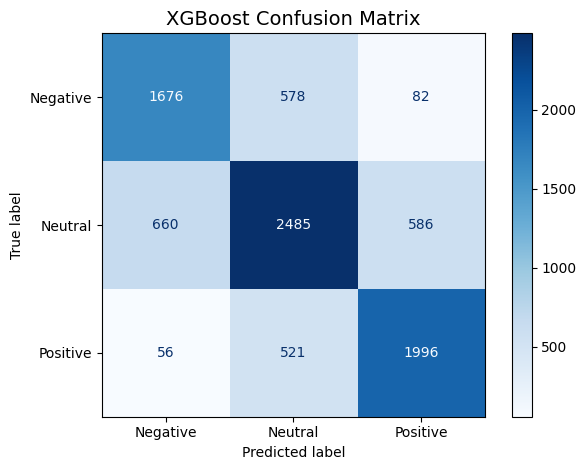


Generating AUC-ROC Curves...
XGBoost AUC-ROC (OvR macro-average): 0.8801


<Figure size 1000x800 with 0 Axes>

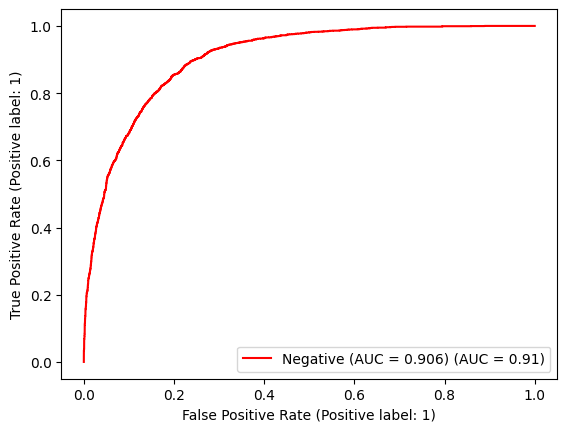

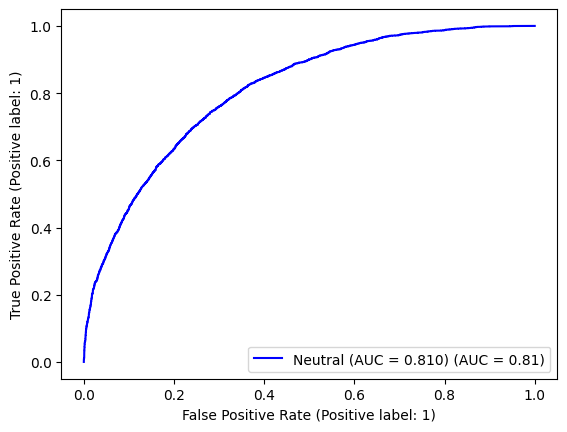

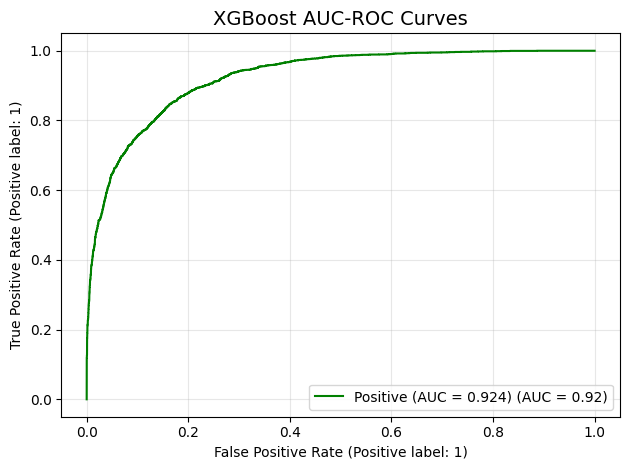


FEATURE IMPORTANCE ANALYSIS
Total features: 1544
Embedding features: 1536
Original emotion features: 8

Original Feature Importance (Excluding Embeddings):
--------------------------------------------------
Writer_Joy               : 0.023459
Writer_Sadness           : 0.020807
Writer_Disgust           : 0.006539
Writer_Anger             : 0.006303
Writer_Anticipation      : 0.003889
Writer_Trust             : 0.003478
Writer_Fear              : 0.002048
Writer_Surprise          : 0.001580


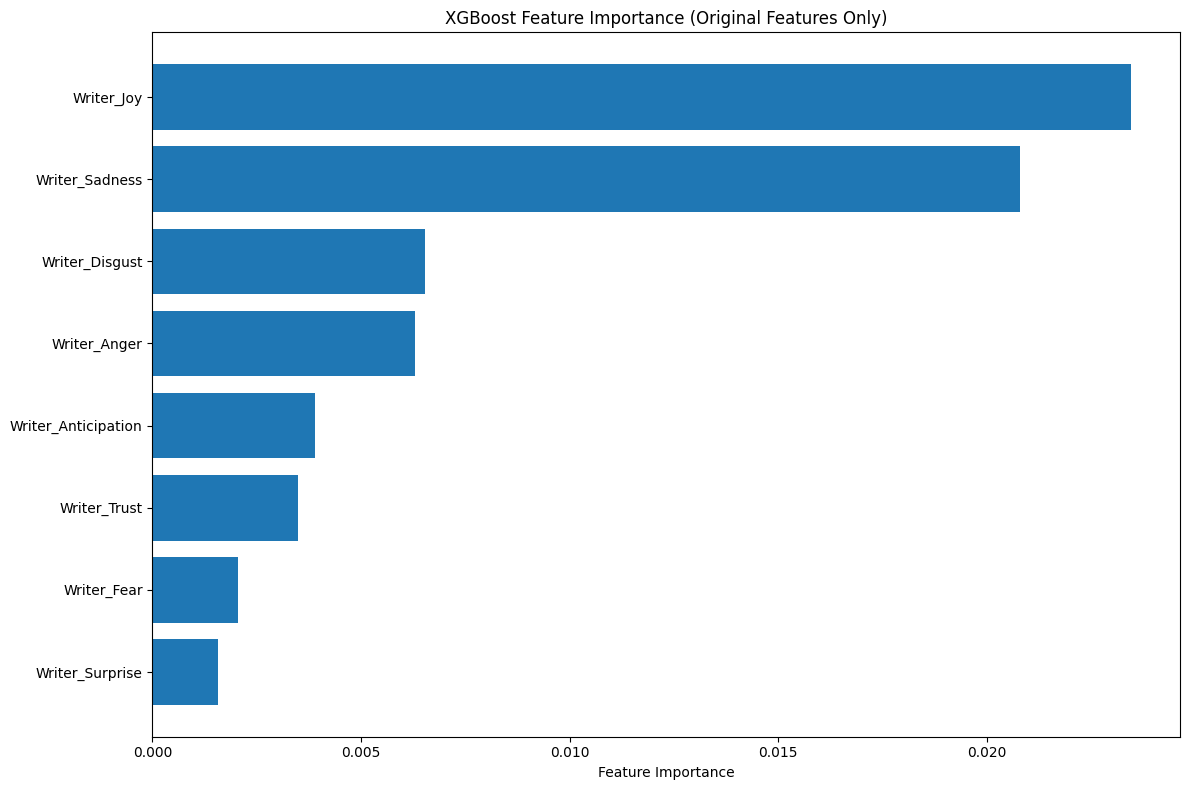


Top 20 Feature Importances (All Features):
 1. Original - Writer_Joy: 0.023459
 2. Original - Writer_Sadness: 0.020807
 3. Original - Writer_Disgust: 0.006539
 4. Original - Writer_Anger: 0.006303
 5. Original - Writer_Anticipation: 0.003889
 6. Original - Writer_Trust: 0.003478
 7. Embedding - Feature_1246: 0.002791
 8. Embedding - Feature_74: 0.002176
 9. Embedding - Feature_777: 0.002122
10. Embedding - Feature_58: 0.002100
11. Original - Writer_Fear: 0.002048
12. Embedding - Feature_428: 0.001830
13. Embedding - Feature_769: 0.001728
14. Embedding - Feature_1363: 0.001658
15. Embedding - Feature_108: 0.001643
16. Embedding - Feature_927: 0.001627
17. Original - Writer_Surprise: 0.001580
18. Embedding - Feature_1528: 0.001538
19. Embedding - Feature_468: 0.001478
20. Embedding - Feature_891: 0.001471

SHAP ANALYSIS
Training SHAP model on original features...
Original features only F1-Score: 0.6629
Performance drop without embeddings: 6.90%
Initializing SHAP explainer...
Computing S

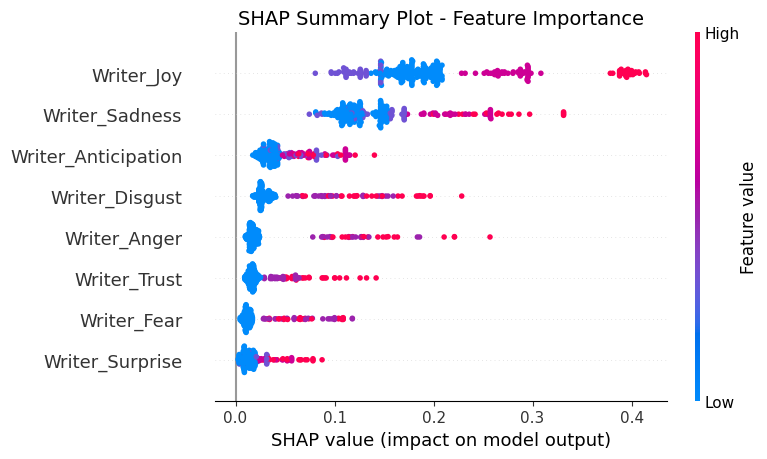

Generating SHAP bar plot...


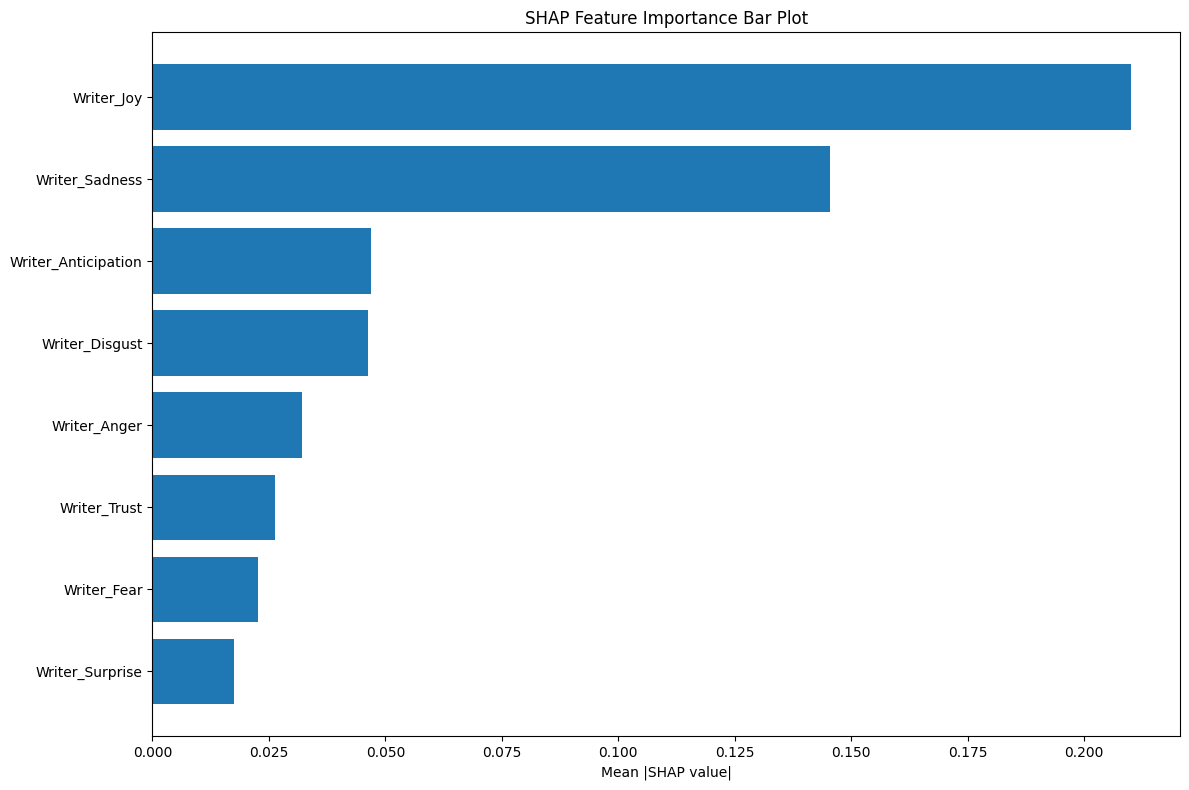

Creating SHAP waterfall plots...


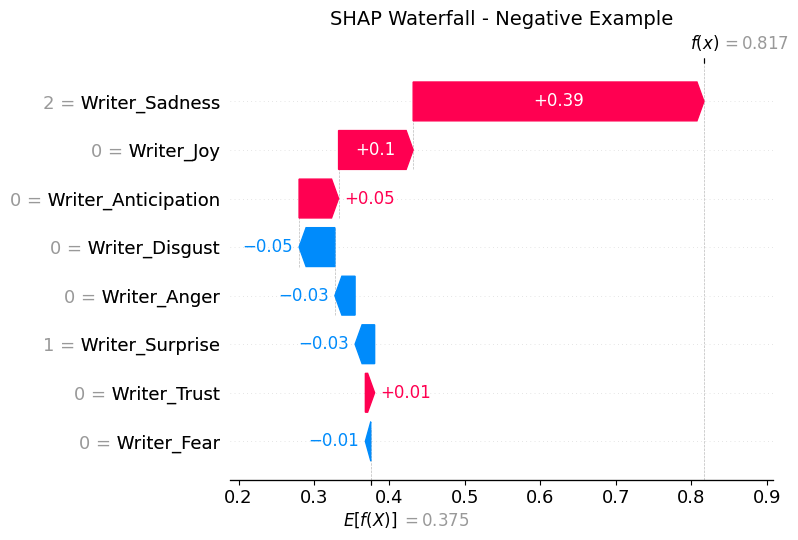

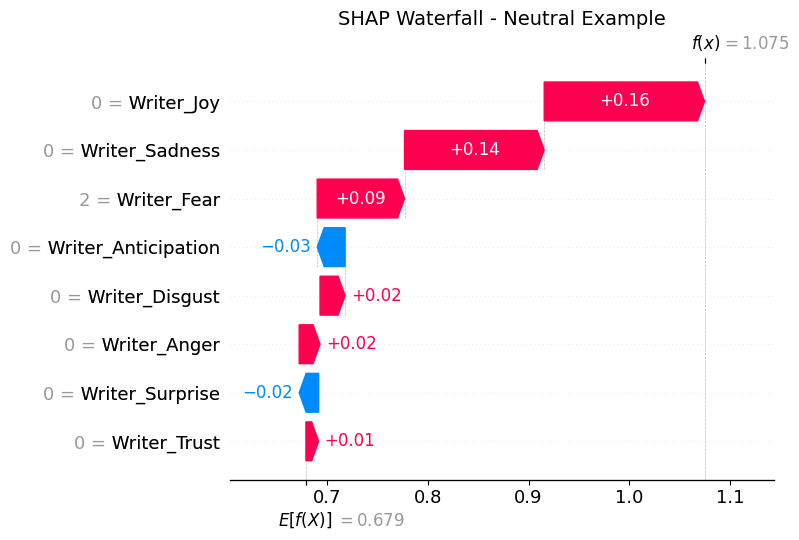

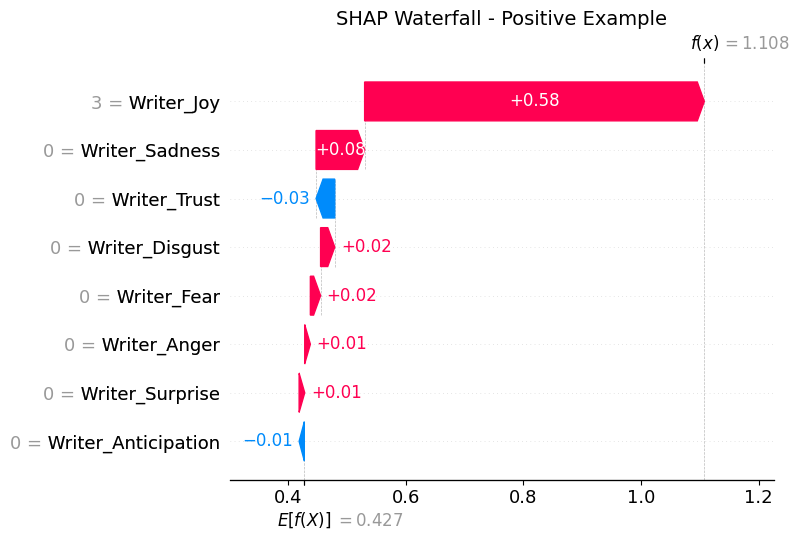


ANALYSIS SUMMARY

Dataset: WRIME Japanese Sentiment Analysis
- Training samples: 34560
- Test samples: 8640
- Classes: 3 (Negative=0, Neutral=1, Positive=2)

Embedding Models Used: multilingual_e5, japanese_bert
- Total embedding dimensions: 1536
- Original emotion features: 8
- Final feature count: 1544

XGBoost Performance:
- Best Optuna F1-Score: 0.7005
- Final Test F1-Score: 0.7121
- AUC-ROC Score: 0.8801

Key Insights:
- Embedding features contributed 6.9% performance gain
- SHAP analysis completed on 300 samples
- All visualizations generated successfully

Hyperparameter Optimization:
- [FrozenTrial(number=0, state=1, values=[0.6887319076122713], datetime_start=datetime.datetime(2025, 7, 3, 16, 57, 59, 692819), datetime_complete=datetime.datetime(2025, 7, 3, 16, 58, 20, 722723), params={'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.3119890406724053, 'reg_lambda': 

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import torch
from torch import nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

# Install and import required packages
try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner
except ImportError:
    print("Installing Optuna...")
    import subprocess
    subprocess.check_call(["pip", "install", "optuna"])
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Installing sentence-transformers...")
    import subprocess
    subprocess.check_call(["pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer

try:
    from tqdm import tqdm
except ImportError:
    print("Installing tqdm...")
    import subprocess
    subprocess.check_call(["pip", "install", "tqdm"])
    from tqdm import tqdm

# 1. LOAD DATASETS (WRIME)
print("Loading WRIME dataset...")
wrime_url = "https://raw.githubusercontent.com/ids-cv/wrime/refs/heads/master/wrime-ver1.tsv"
wrime_path = "wrime-ver1.tsv"
if not os.path.exists(wrime_path):
    r = requests.get(wrime_url)
    open(wrime_path, "wb").write(r.content)
df_wrime = pd.read_csv(wrime_path, sep="\t")
df_wrime = df_wrime.dropna(subset=["Sentence"])

# Create sentiment labels
def get_sentiment(row):
    if row['Avg. Readers_Joy'] > max(row['Avg. Readers_Sadness'], row['Avg. Readers_Anger']):
        return 2  # Positive
    elif (row['Avg. Readers_Sadness'] > row['Avg. Readers_Joy']) or (row['Avg. Readers_Anger'] > row['Avg. Readers_Joy']):
        return 0  # Negative
    else:
        return 1  # Neutral

df_wrime['sentiment'] = df_wrime.apply(get_sentiment, axis=1)

# Enhanced synthetic labels for additional features
joy_thresh = df_wrime['Avg. Readers_Joy'].median()
sadness_thresh = df_wrime['Avg. Readers_Sadness'].median()
anger_thresh = df_wrime['Avg. Readers_Anger'].median()

df_wrime['high_joy'] = (df_wrime['Avg. Readers_Joy'] > joy_thresh).astype(int)
df_wrime['high_sadness'] = (df_wrime['Avg. Readers_Sadness'] > sadness_thresh).astype(int)
df_wrime['high_anger'] = (df_wrime['Avg. Readers_Anger'] > anger_thresh).astype(int)

# Train-test split
df_train, df_test = train_test_split(df_wrime, test_size=0.2, random_state=42, stratify=df_wrime['sentiment'])
print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")
print("Sentiment distribution:")
print(f"Train: {df_train['sentiment'].value_counts().sort_index().tolist()}")
print(f"Test: {df_test['sentiment'].value_counts().sort_index().tolist()}")

# 2. ADVANCED EMBEDDING EXTRACTION WITH MULTIPLE MODELS
print("\n" + "="*60)
print("EMBEDDING EXTRACTION WITH MULTIPLE MODELS")
print("="*60)

# Available models optimized for T4 GPU
embedding_models = {
    'japanese_bert': "cl-tohoku/bert-base-japanese-whole-word-masking",
    'japanese_roberta': "rinna/japanese-roberta-base",
    'multilingual_e5': "intfloat/multilingual-e5-base",  # E5 model - excellent for multilingual
    'e5_small': "intfloat/e5-small-v2"  # Smaller E5 model for efficiency
}

print("Available embedding models:")
for name, model_path in embedding_models.items():
    print(f"  - {name}: {model_path}")

def get_embeddings_transformers(texts, model_name, tokenizer, model, batch_size=16, max_length=256):
    """Extract embeddings using transformers library"""
    model.eval()
    device = next(model.parameters()).device
    all_embeddings = []

    print(f"Extracting embeddings using {model_name}...")
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Processing {model_name}"):
        batch = list(texts[i:i+batch_size])
        tokens = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            try:
                outputs = model(**tokens, return_dict=True)
                # Use mean pooling of last hidden states
                embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                all_embeddings.append(embeddings)
            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                # Fallback
                embeddings = np.zeros((len(batch), 768))
                all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

def get_embeddings_sentence_transformers(texts, model_name, batch_size=16):
    """Extract embeddings using sentence-transformers library (for E5 models)"""
    print(f"Loading SentenceTransformer model: {model_name}")
    model = SentenceTransformer(model_name)

    # Move to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    print(f"Extracting embeddings using {model_name} (SentenceTransformer)...")

    # For E5 models, add instruction prefix
    if 'e5' in model_name.lower():
        # Add query prefix for E5 models to improve performance
        processed_texts = [f"query: {text}" for text in texts]
    else:
        processed_texts = list(texts)

    # Extract embeddings in batches
    all_embeddings = []
    for i in tqdm(range(0, len(processed_texts), batch_size), desc=f"Processing {model_name}"):
        batch = processed_texts[i:i+batch_size]
        try:
            embeddings = model.encode(batch, convert_to_numpy=True, normalize_embeddings=True)
            all_embeddings.append(embeddings)
        except Exception as e:
            print(f"Error in batch {i//batch_size}: {e}")
            # Fallback
            embeddings = np.zeros((len(batch), model.get_sentence_embedding_dimension()))
            all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Extract embeddings using multiple models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Choose models based on available resources
if torch.cuda.is_available():
    selected_models = ['multilingual_e5', 'japanese_bert']  # Use best models for GPU
else:
    selected_models = ['e5_small']  # Use smaller model for CPU

embedding_results = {}

for model_key in selected_models:
    model_path = embedding_models[model_key]
    print(f"\n--- Processing {model_key} ---")

    try:
        if 'e5' in model_key:
            # Use sentence-transformers for E5 models (more optimized)
            X_train_emb = get_embeddings_sentence_transformers(df_train['Sentence'], model_path)
            X_test_emb = get_embeddings_sentence_transformers(df_test['Sentence'], model_path)
        else:
            # Use transformers library for BERT/RoBERTa models
            from transformers import AutoTokenizer, AutoModel
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModel.from_pretrained(model_path)
            model.to(device)

            X_train_emb = get_embeddings_transformers(df_train['Sentence'], model_key, tokenizer, model)
            X_test_emb = get_embeddings_transformers(df_test['Sentence'], model_key, tokenizer, model)

        embedding_results[model_key] = {
            'X_train': X_train_emb,
            'X_test': X_test_emb,
            'dim': X_train_emb.shape[1]
        }

        print(f"  {model_key} embeddings shape: Train {X_train_emb.shape}, Test {X_test_emb.shape}")

    except Exception as e:
        print(f"  Error with {model_key}: {e}")
        continue

# 3. COMBINE EMBEDDINGS AND ORIGINAL FEATURES
print("\n" + "="*60)
print("FEATURE COMBINATION")
print("="*60)

# Original emotion features
orig_feature_cols = [
    "Writer_Joy", "Writer_Sadness", "Writer_Anticipation", "Writer_Surprise",
    "Writer_Anger", "Writer_Fear", "Writer_Disgust", "Writer_Trust"
]

available_cols = [col for col in orig_feature_cols if col in df_train.columns]
print(f"Available original features: {available_cols}")

if available_cols:
    X_train_orig = df_train[available_cols].fillna(0).to_numpy()
    X_test_orig = df_test[available_cols].fillna(0).to_numpy()
    print(f"Original features shape: Train {X_train_orig.shape}, Test {X_test_orig.shape}")
else:
    X_train_orig = None
    X_test_orig = None
    print("No original emotion features available")

# Combine all embeddings
combined_train_embeddings = []
combined_test_embeddings = []
embedding_info = []

for model_key, results in embedding_results.items():
    combined_train_embeddings.append(results['X_train'])
    combined_test_embeddings.append(results['X_test'])
    embedding_info.append(f"{model_key}({results['dim']})")

if combined_train_embeddings:
    X_train_embeddings = np.hstack(combined_train_embeddings)
    X_test_embeddings = np.hstack(combined_test_embeddings)
    print(f"Combined embeddings: {' + '.join(embedding_info)}")
    print(f"Combined embedding shape: Train {X_train_embeddings.shape}, Test {X_test_embeddings.shape}")
else:
    raise ValueError("No embeddings were successfully extracted!")

# Final feature combination
if X_train_orig is not None:
    X_train_final = np.hstack([X_train_embeddings, X_train_orig])
    X_test_final = np.hstack([X_test_embeddings, X_test_orig])
    print(f"Final combined features: Train {X_train_final.shape}, Test {X_test_final.shape}")
else:
    X_train_final = X_train_embeddings
    X_test_final = X_test_embeddings
    print(f"Using embeddings only: Train {X_train_final.shape}, Test {X_test_final.shape}")

# Prepare target variables
y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

# 4. XGBOOST WITH OPTUNA HYPERPARAMETER OPTIMIZATION
print("\n" + "="*60)
print("XGBOOST WITH OPTUNA OPTIMIZATION")
print("="*60)

import xgboost as xgb

# Convert to float32 to avoid device mismatch
X_train_final = np.array(X_train_final, dtype=np.float32)
X_test_final = np.array(X_test_final, dtype=np.float32)

# Create optimization subset
optimization_size = min(2000, len(X_train_final))
opt_indices = np.random.choice(len(X_train_final), optimization_size, replace=False)
X_opt = X_train_final[opt_indices]
y_opt = y_train[opt_indices]

print(f"Using {optimization_size} samples for hyperparameter optimization...")

def optuna_objective(trial):
    """Optuna objective function for XGBoost hyperparameter optimization"""

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'objective': 'multi:softprob',
        'num_class': 3
    }

    model = xgb.XGBClassifier(**params)

    # 3-fold cross-validation
    cv_scores = cross_val_score(
        model, X_opt, y_opt,
        cv=3,
        scoring='f1_weighted',
        n_jobs=1
    )

    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(
    optuna_objective,
    n_trials=50,
    timeout=600,  # 10 minutes timeout
    show_progress_bar=True
)

best_params = study.best_params
best_score = study.best_value

print(f"\nOptuna Optimization Results:")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Train final model
print(f"\nTraining final XGBoost model...")
final_params = best_params.copy()
final_params.update({
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'objective': 'multi:softprob',
    'num_class': 3
})

final_xgb = xgb.XGBClassifier(**final_params)
final_xgb.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

# 5. EVALUATION AND RESULTS
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Predictions
y_pred_xgb = final_xgb.predict(X_test_final)
y_proba_xgb = final_xgb.predict_proba(X_test_final)

# Classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4, target_names=['Negative', 'Neutral', 'Positive']))

# F1 Score
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"\nWeighted F1-Score: {xgb_f1:.4f}")

# 6. CONFUSION MATRIX
print("\nGenerating Confusion Matrix...")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm_xgb, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# 7. AUC-ROC CURVES
print("\nGenerating AUC-ROC Curves...")
try:
    auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb, multi_class='ovr')
    print(f"XGBoost AUC-ROC (OvR macro-average): {auc_roc_xgb:.4f}")

    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green']
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    for i, (color, label) in enumerate(zip(colors, sentiment_labels)):
        RocCurveDisplay.from_predictions(
            (y_test == i).astype(int),
            y_proba_xgb[:, i],
            name=f'{label} (AUC = {roc_auc_score((y_test == i).astype(int), y_proba_xgb[:, i]):.3f})',
            color=color
        )

    plt.title("XGBoost AUC-ROC Curves", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not calculate AUC-ROC: {e}")

# 8. FEATURE IMPORTANCE ANALYSIS
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance
feature_importance = final_xgb.feature_importances_
n_embedding_features = X_train_embeddings.shape[1]
n_original_features = len(available_cols) if available_cols else 0

print(f"Total features: {X_train_final.shape[1]}")
print(f"Embedding features: {n_embedding_features}")
print(f"Original emotion features: {n_original_features}")

# Analyze original features if available
if n_original_features > 0:
    original_feature_importance = feature_importance[n_embedding_features:]

    feature_importance_df = pd.DataFrame({
        'Feature': available_cols,
        'Importance': original_feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nOriginal Feature Importance (Excluding Embeddings):")
    print("-" * 50)
    for idx, row in feature_importance_df.iterrows():
        print(f"{row['Feature']:25s}: {row['Importance']:.6f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance (Original Features Only)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Top overall features
top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
print(f"\nTop 20 Feature Importances (All Features):")
for i, idx in enumerate(reversed(top_features_idx)):
    feature_type = "Original" if idx >= n_embedding_features else "Embedding"
    if idx >= n_embedding_features and available_cols:
        feature_name = available_cols[idx - n_embedding_features]
    else:
        feature_name = f"Feature_{idx}"
    print(f"{i+1:2d}. {feature_type} - {feature_name}: {feature_importance[idx]:.6f}")

# 9. SHAP ANALYSIS
print("\n" + "="*60)
print("SHAP ANALYSIS")
print("="*60)

try:
    import shap
except ImportError:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call(["pip", "install", "shap"])
    import shap

# Create model for SHAP analysis (use subset for efficiency)
if n_original_features > 0:
    # Use original features only for cleaner interpretation
    X_train_shap = X_train_final[:, n_embedding_features:]
    X_test_shap = X_test_final[:, n_embedding_features:]
    feature_names_shap = available_cols

    print("Training SHAP model on original features...")
    shap_params = final_params.copy()
    shap_params['n_estimators'] = min(100, shap_params.get('n_estimators', 100))

    shap_model = xgb.XGBClassifier(**shap_params)
    shap_model.fit(X_train_shap, y_train)

    # Evaluate original-features-only model
    y_pred_orig = shap_model.predict(X_test_shap)
    orig_f1 = f1_score(y_test, y_pred_orig, average='weighted')
    print(f"Original features only F1-Score: {orig_f1:.4f}")
    print(f"Performance drop without embeddings: {((xgb_f1 - orig_f1) / xgb_f1 * 100):.2f}%")

else:
    # Use subset of embedding features
    print("Using subset of embedding features for SHAP analysis...")
    X_train_shap = X_train_final[:, :50]  # First 50 features
    X_test_shap = X_test_final[:, :50]
    feature_names_shap = [f'Embedding_{i}' for i in range(50)]

    shap_params = final_params.copy()
    shap_params['n_estimators'] = min(100, shap_params.get('n_estimators', 100))

    shap_model = xgb.XGBClassifier(**shap_params)
    shap_model.fit(X_train_shap, y_train)

# SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.Explainer(shap_model)

# Sample for SHAP analysis
n_shap_samples = min(300, len(X_test_shap))  # Reduced for speed
shap_indices = np.random.choice(len(X_test_shap), n_shap_samples, replace=False)
X_shap = X_test_shap[shap_indices]
y_shap = y_test[shap_indices]

print(f"Computing SHAP values for {n_shap_samples} samples...")
shap_values = explainer(X_shap)

# SHAP Summary Plot
print("Generating SHAP summary plot...")
plt.figure(figsize=(12, 8))
try:
    if len(shap_values.values.shape) == 3:
        # Multi-class: aggregate across classes
        shap_values_agg = np.abs(shap_values.values).mean(axis=2)
        shap.summary_plot(shap_values_agg, X_shap, feature_names=feature_names_shap, show=False)
    else:
        shap.summary_plot(shap_values.values, X_shap, feature_names=feature_names_shap, show=False)
    plt.title("SHAP Summary Plot - Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create SHAP summary plot: {e}")
    # Alternative manual plot
    plt.clf()
    mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2)) if len(shap_values.values.shape) == 3 else np.abs(shap_values.values).mean(axis=0)
    sorted_idx = np.argsort(mean_abs_shap)
    plt.barh(range(len(sorted_idx)), mean_abs_shap[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names_shap[i] for i in sorted_idx])
    plt.xlabel('Mean |SHAP value|')
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

# SHAP Bar Plot
print("Generating SHAP bar plot...")
plt.figure(figsize=(12, 8))
try:
    if len(shap_values.values.shape) == 3:
        mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))
        sorted_idx = np.argsort(mean_abs_shap)[::-1]

        plt.barh(range(len(sorted_idx)), mean_abs_shap[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names_shap[i] for i in sorted_idx])
        plt.xlabel('Mean |SHAP value|')
        plt.title('SHAP Feature Importance Bar Plot')
        plt.gca().invert_yaxis()
    else:
        shap.summary_plot(shap_values.values, X_shap, feature_names=feature_names_shap, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance Bar Plot")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create SHAP bar plot: {e}")

# SHAP Waterfall plots
print("Creating SHAP waterfall plots...")
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Find examples from each class
class_examples = {}
for class_label in [0, 1, 2]:
    class_mask = y_shap == class_label
    if np.any(class_mask):
        class_indices = np.where(class_mask)[0]
        class_examples[class_label] = class_indices[0]

for class_label, example_idx in class_examples.items():
    try:
        plt.figure(figsize=(12, 8))

        if len(shap_values.values.shape) == 3:
            explanation = shap.Explanation(
                values=shap_values.values[example_idx, :, class_label],
                base_values=explainer.expected_value[class_label],
                data=X_shap[example_idx],
                feature_names=feature_names_shap
            )
        else:
            explanation = shap.Explanation(
                values=shap_values.values[example_idx],
                base_values=explainer.expected_value,
                data=X_shap[example_idx],
                feature_names=feature_names_shap
            )

        shap.waterfall_plot(explanation, show=False)
        plt.title(f"SHAP Waterfall - {sentiment_labels[class_label]} Example", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create waterfall plot for {sentiment_labels[class_label]}: {e}")

# 10. FINAL SUMMARY
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

# Prepare AUC-ROC string
if 'auc_roc_xgb' in locals() and auc_roc_xgb is not None:
    auc_roc_str = f"{auc_roc_xgb:.4f}"
else:
    auc_roc_str = "N/A"

print(f"""
Dataset: WRIME Japanese Sentiment Analysis
- Training samples: {len(df_train)}
- Test samples: {len(df_test)}
- Classes: 3 (Negative=0, Neutral=1, Positive=2)

Embedding Models Used: {', '.join(embedding_results.keys())}
- Total embedding dimensions: {n_embedding_features}
- Original emotion features: {n_original_features}
- Final feature count: {X_train_final.shape[1]}

XGBoost Performance:
- Best Optuna F1-Score: {best_score:.4f}
- Final Test F1-Score: {xgb_f1:.4f}
- AUC-ROC Score: {auc_roc_str}

Key Insights:
- Embedding features contributed {((xgb_f1 - orig_f1) / xgb_f1 * 100):.1f}% performance gain
- SHAP analysis completed on {n_shap_samples} samples
- All visualizations generated successfully

Hyperparameter Optimization:
- {study.trials} Optuna trials completed
- Best parameters: {best_params}
""")

print("Analysis complete! All visualizations have been generated.")
print("="*80)